In [1]:
import os
import sys
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torch
import matplotlib.pyplot as plt
from Naive_DAE import Naive_DAE,Dropout_DAE
import AE_Stats
from load_data_fn import load_data,load_data_no_filter

from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, TensorDataset
import importlib


In [31]:
import importlib
importlib.reload(AE_Stats)

<module 'AE_Stats' from '/uscms_data/d3/nswood/Notebooks/AE_Dev/AE_Stats.py'>

# Load Data

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
n = 80

arr = torch.load('data/TTBAR/ttbar_1_greater_0_sim')
if n > 0:
    for i in range(n):
        arr = torch.vstack([arr,torch.load(f'data/TTBAR/ttbar_{int(n+2)}_greater_0_sim')])



In [4]:
print(f'There are {len(arr)} wafers with sim energy > 0 ')
print(f'mean calcq is: {torch.mean(arr[:,0:48])}')
print(f'max calcq is: {torch.max(arr[:,0:48])}')

There are 892079 wafers with sim energy > 0 
mean calcq is: 16.369503009262633
max calcq is: 10788.0


In [5]:
dt_1 = []


for a in arr:
    
    if a[-4].item() ==0.: 
        dt_1.append(a)
    
    
dt_1 = torch.vstack(dt_1).float()
print(f'{len(dt_1)} wafers of type 0')
print(f'mean calcq: {torch.mean(dt_1[:,0:48])}')
print(f'std calcq: {torch.std(dt_1[:,0:48])}')
mean_dt_1 = torch.mean(dt_1[:,0:48])
std_dt_1 = torch.std(dt_1[:,0:48])
dt_1[:,0:48] = (dt_1[:,0:48]-mean_dt_1)/torch.std(dt_1[:,0:48])
dt_1 = dt_1.to(device)

432654 wafers of type 0
mean calcq: 27.600881576538086
std calcq: 51.770050048828125


# Loss Functions

In [74]:
def AE_MSE(data,pred):
    return torch.mean(torch.sum((data-pred)**2,dim=1))

def AE_MAE(data,pred):
    return torch.mean(torch.sum(torch.abs(data-pred),dim=1))

def weighted_AE_MSE(data, pred):
    return torch.mean(torch.sum((data[:,0:48])**2,dim=1)*torch.sum((data-pred)**2,dim=1))

def dif_weighted_AE_MSE(data, pred,alpha = 0.2):
    return torch.mean(((torch.sum(data[:,0:48]**2,dim=1)**0.5)*alpha+1)*(torch.sum((data-pred)**2,dim=1)))

def log_dif_weighted_AE_MSE(data, pred,alpha = 1):
    return torch.mean(torch.log((torch.sum(data[:,0:48]**2,dim=1)**0.5)*alpha+1)*(torch.sum((data-pred)**2,dim=1)))

def calcQ_Error(data,pred, mean,std):
    return torch.mean(torch.sum(torch.abs(data-pred),dim=1))*std
    
def std_error(data,pred):
    return torch.mean(torch.sum(torch.abs(torch.subtract(data,pred)),dim=1))

# def AE_MSE_avg(data,pred):
#     return torch.mean(torch.max(torch.ones(len(data)),1.5-0.12*((torch.sum(data[:,0:48]**2,dim=1)**0.5)-5.2586)**2)*(torch.sum((data-pred)**2,dim=1)))


def new_loss(data,pred,epoch,mean,std,alpha = 0.2,cut = 200):
    #Reconstruction
    error = dif_weighted_AE_MSE(data,pred,alpha = alpha)
    if epoch < cut:
        return error + std_error(data,pred)
    else:
        
        

        return  error + std_error(data,pred) + 0.001*sum_error*np.min([(epoch-cut)/cut,1])

# Study: Explore if we can train a AE exclusively for different ranges of wafers occupancy
We are having issues working to maximize performance on high occupancy wafers and average wafers. High occupancy wafers seem to dominate the mean and many loss terms. They are crucial to encode well as they can include much of the important physical information, however, doing this at the detriment of well encodings for the vast majority of the average wafers is not satisfactory. 

## Model Training Functions

In [53]:
def eval_model(model, dt, size_train, size_test):
    
    test_loc = dt[-size_test:]
    # train = torch.vstack([train,largest[0:1000]] )
    train_loc=train_loc[torch.randperm(train_loc.size()[0])]
    test_loc=test_loc[torch.randperm(test_loc.size()[0])]
    train_loc_d1_flat = DataLoader(
        TensorDataset(torch.Tensor(train_loc)),
        batch_size=100,
        shuffle=False
    )

    test_loc_d1_flat = DataLoader(
        TensorDataset(torch.Tensor(test_loc)),
        batch_size=100,
        shuffle=False
    )

    train = dt[0:size_train,0:48]
    test = dt[-size_test:,0:48]
    # train = torch.vstack([train,largest[0:1000]] )
    train=train[torch.randperm(train.size()[0])]
    test=test[torch.randperm(test.size()[0])]
    train_d1_flat = DataLoader(
        TensorDataset(torch.Tensor(train)),
        batch_size=100,
        shuffle=False
    )

    test_d1_flat = DataLoader(
        TensorDataset(torch.Tensor(test)),
        batch_size=100,
        shuffle=False
    )
    #fine-tune autoencoder
    #batch 500
    test = dt[-size_test:,0:48]
    optimizer = optim.Adam(model.parameters(), lr,weight_decay=5e-2)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',factor = 0.5)
    test = dt[-size_test:,0:48]

    AE_Stats.gen_all_stats(model(dt[-size_test:,0:48]).cpu(),dt[-size_test:,0:48].cpu(),dt[-size_test:].cpu())


In [75]:
def train_model(model, dt, size_train, size_test,label,cur_directory,path, num_epochs = 200, lr = 0.001,batch = 50):
    train_loc = dt[0:size_train]
    test_loc = dt[-size_test:]
    # train = torch.vstack([train,largest[0:1000]] )
    train_loc=train_loc[torch.randperm(train_loc.size()[0])]
    test_loc=test_loc[torch.randperm(test_loc.size()[0])]
    train_loc_d1_flat = DataLoader(
        TensorDataset(torch.Tensor(train_loc)),
        batch_size=batch,
        shuffle=False
    )

    test_loc_d1_flat = DataLoader(
        TensorDataset(torch.Tensor(test_loc)),
        batch_size=batch,
        shuffle=False
    )

    train = dt[0:size_train,0:48]
    test = dt[-size_test:,0:48]
    # train = torch.vstack([train,largest[0:1000]] )
    train=train[torch.randperm(train.size()[0])]
    test=test[torch.randperm(test.size()[0])]
    train_d1_flat = DataLoader(
        TensorDataset(torch.Tensor(train)),
        batch_size=batch,
        shuffle=False
    )

    test_d1_flat = DataLoader(
        TensorDataset(torch.Tensor(test)),
        batch_size=batch,
        shuffle=False
    )
    #fine-tune autoencoder
    #batch 500
    
    optimizer = optim.Adam(model.parameters(), lr,weight_decay=5e-2)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',factor = 0.5)
    
    all_test_losses = []
    all_train_losses = []
    # train
    running_loss = float("inf")
    for epoch in range(num_epochs):
        
        losses = []

        for i, data_list in enumerate(train_d1_flat):
            model.train()
            data = data_list[0]
            v_pred = model(data)

    #         batch_loss = loss(data[:,0:48], v_pred,epoch,std_dt,mean_dt,alpha = a) # difference between actual and reconstructed   
            batch_loss = loss(data[:,0:48], v_pred,epoch,mean,std)

            all_train_losses.append(batch_loss.item())
            losses.append(batch_loss.item())
            optimizer.zero_grad()
            batch_loss.backward()
            optimizer.step()
        scheduler.step(batch_loss)
        data_test = test
        model.eval()
        test_pred = model(data_test)
        batch_test = loss(data_test[:,0:48], test_pred,epoch,mean,std)
        all_test_losses.append(batch_test.item())
        running_loss = np.mean(losses)
        runningest_loss = batch_test.item()
        if epoch % 50 == 0:
            print('Epoch {}, lr {}'.format(
                epoch, optimizer.param_groups[0]['lr']))

            print(f"Epoch {epoch}: Train {running_loss}, Test {runningest_loss}")
    model.eval()
    AE_Stats.gen_all_stats(model(dt[-size_test:,0:48]).cpu(),dt[-size_test:,0:48].cpu(),dt[-size_test:].cpu())
    torch.save(model,f'{path}/{label}')

## Sorting data 

In [50]:
dt_outlier = []
dt_m1 = []
dt_m2 = []
dt_m3 = []
dt_m4 = []
dt_low = []

for d in dt_1:
    if torch.norm(d[0:48]).item() < 3:
        dt_low.append(d)
    elif torch.norm(d[0:48]).item() < 4:
        dt_m1.append(d)
    elif torch.norm(d[0:48]).item() < 5:
        dt_m2.append(d)
    elif torch.norm(d[0:48]).item() < 6.5:
        dt_m3.append(d)
    elif torch.norm(d[0:48]).item() < 10:
        dt_m4.append(d)
    else:
        dt_outlier.append(d)
        
dt_outlier = torch.vstack(dt_outlier).to(device)
dt_m1 = torch.vstack(dt_m1).to(device)
dt_m2 = torch.vstack(dt_m2).to(device)
dt_m3 = torch.vstack(dt_m3).to(device)
dt_m4 = torch.vstack(dt_m4).to(device)
dt_low = torch.vstack(dt_low).to(device)

In [ ]:
print(f'There are {len(dt_outlier)} outliers')
# print(f'There are {len(dt_m1)} m1 ')
# print(f'There are {len(dt_m2)} m2 ')
# print(f'There are {len(dt_m3)} m3 ')
# print(f'There are {len(dt_m4)} m4 ')
print(f'There are {len(dt_low)} low ')

In [ ]:
data = [[dt_low,'low'], [dt_m1,'m1'],[dt_m2,'m2'],[dt_m3,'m3'],[dt_m4,'m4'], [dt_outlier,'outlier']]
train_models(data)

In [31]:
dt_outlier = []
dt_m1 = []
dt_m2 = []
dt_low = []

for d in dt_1:
    if torch.norm(d[0:48]).item() < 3:
        dt_low.append(d)
    elif torch.norm(d[0:48]).item() < 5:
        dt_m1.append(d)
    elif torch.norm(d[0:48]).item() < 10:
        dt_m2.append(d)
    else:
        dt_outlier.append(d)
        
dt_outlier = torch.vstack(dt_outlier).to(device)
dt_m1 = torch.vstack(dt_m1).to(device)
dt_m2 = torch.vstack(dt_m2).to(device)
dt_low = torch.vstack(dt_low).to(device)

In [38]:
zloss = new_loss
mean = mean_dt_1
std = std_dt_1

In [66]:
data = [[dt_low,'low'], [dt_m1,'m1'],[dt_m2,'m2'],[dt_outlier,'outlier']]
# data = [[dt_low[0:20],'low']]

TRAINING MODEL low
Epoch 0, lr 0.001
Epoch 0: Train 8.003078307756564, Test 5.647418022155762
Epoch 50, lr 0.001
Epoch 50: Train 2.6205734479718092, Test 2.5633432865142822
Epoch 100, lr 0.000125
Epoch 100: Train 0.7315817021015214, Test 0.398974746465683
Epoch 150, lr 3.125e-05
Epoch 150: Train 0.48688656110770817, Test 0.13156913220882416
MSE 0.002129125874489546
Median 9.259835496777669e-05
Standard Devitaion 0.009193377569317818
Average std error 0.07362724840641022
Average % Error of Energy Reconstruction 0.9422074556350708


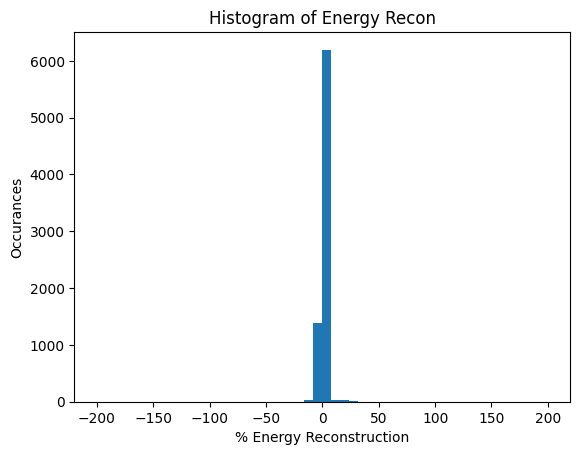

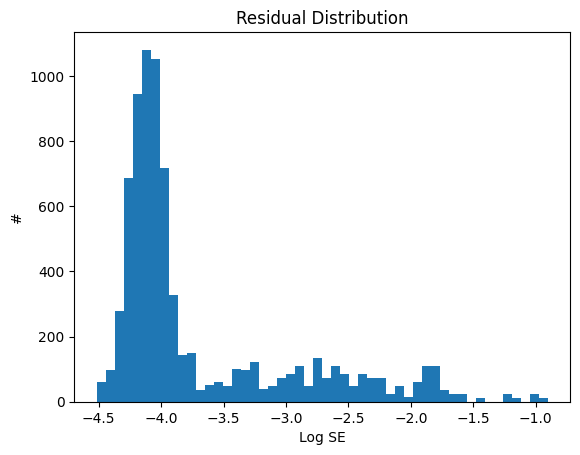

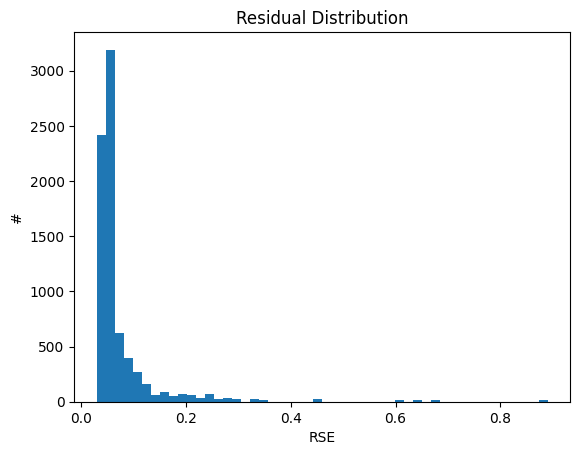

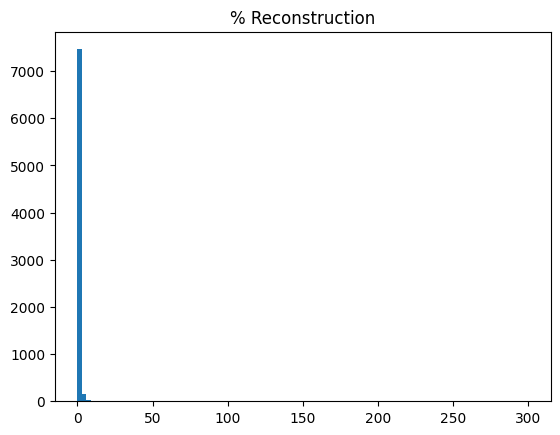

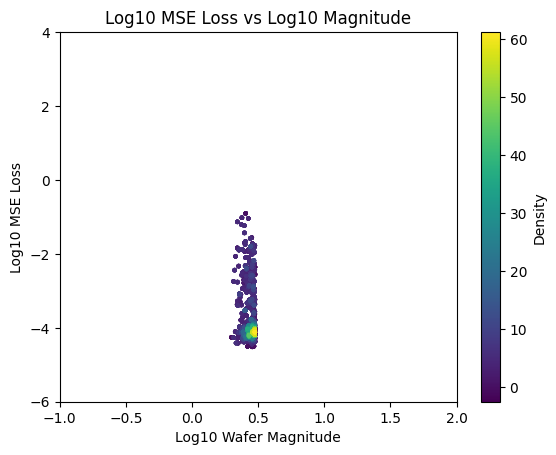

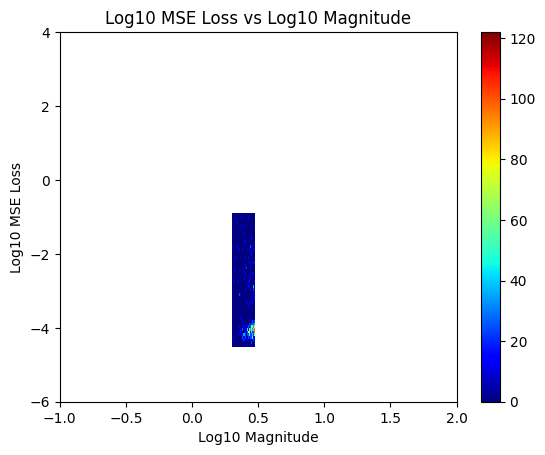

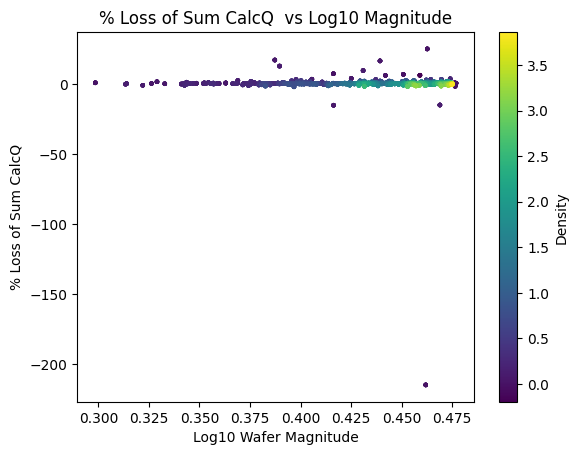

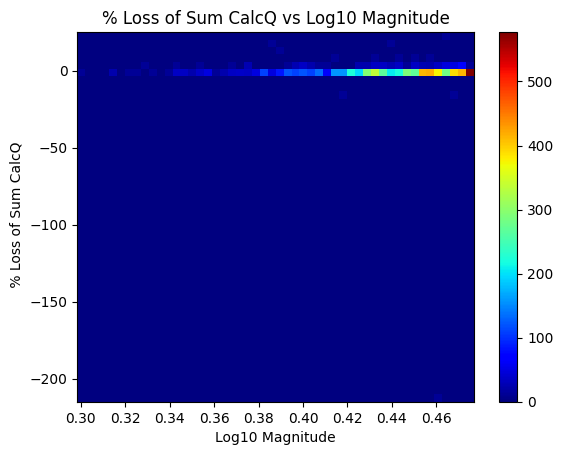

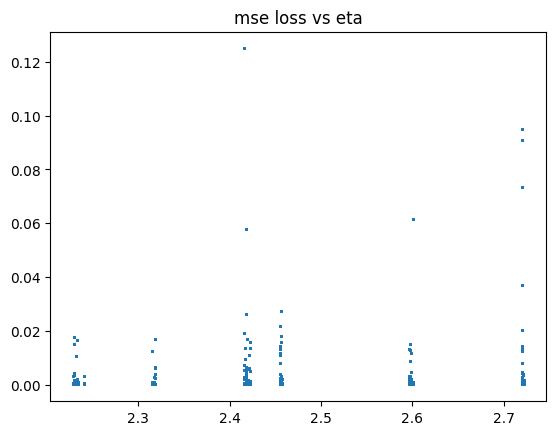

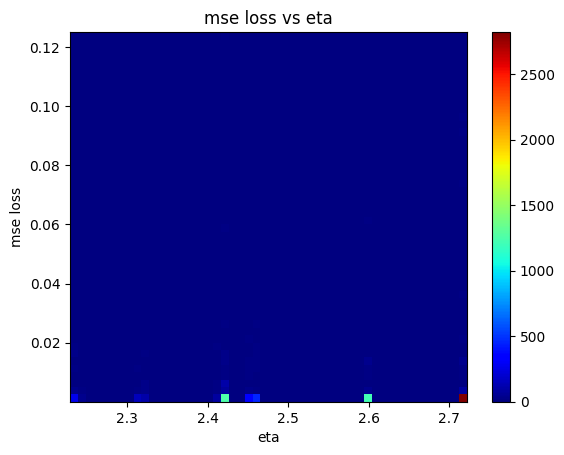

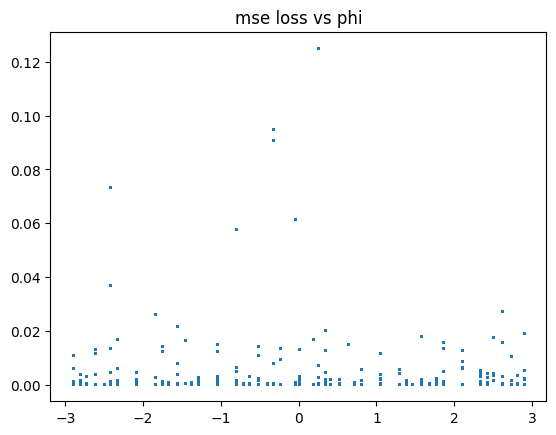

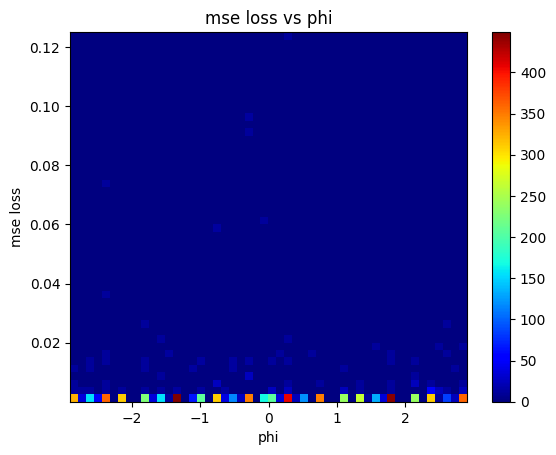

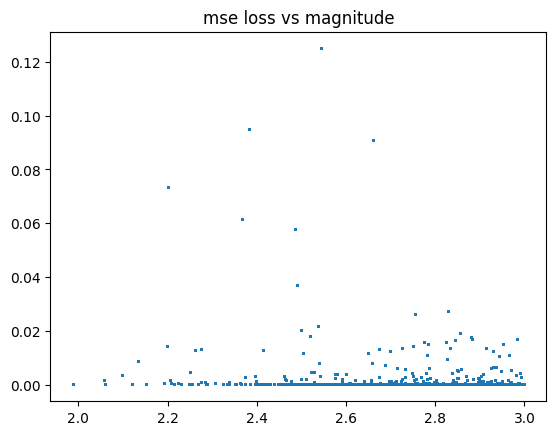

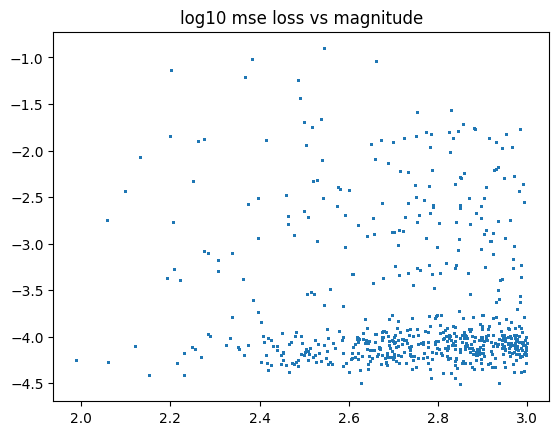

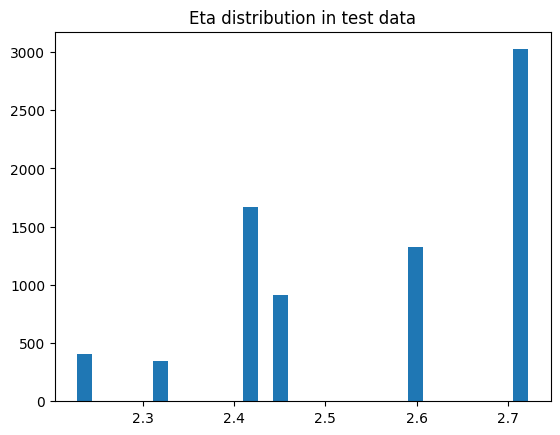

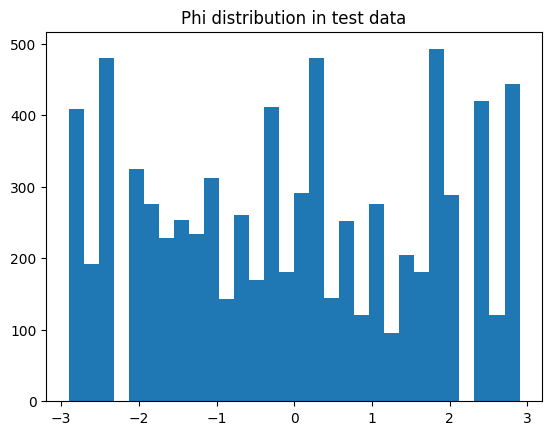

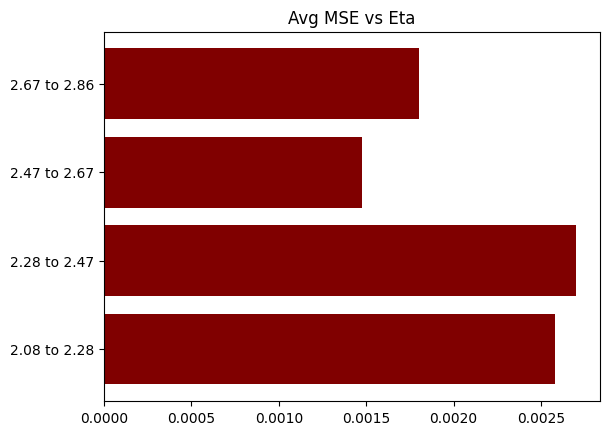

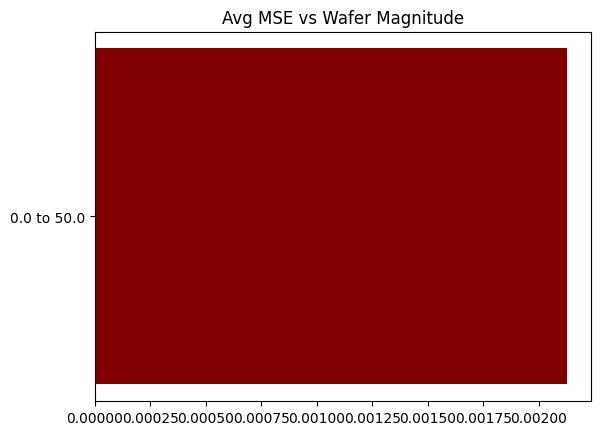

TRAINING MODEL m1
Epoch 0, lr 0.001
Epoch 0: Train 16.886299423925028, Test 16.089534759521484
Epoch 50, lr 0.0005
Epoch 50: Train 11.936087926906287, Test 11.789407730102539
Epoch 100, lr 0.00025
Epoch 100: Train 7.462846187435063, Test 7.054798126220703
Epoch 150, lr 6.25e-05
Epoch 150: Train 6.156284484827715, Test 5.695786476135254
MSE 0.8623253703117371
Median 0.7300652861595154
Standard Devitaion 0.6070903539657593
Average std error 3.9307429790496826
Average % Error of Energy Reconstruction 41.96245193481445


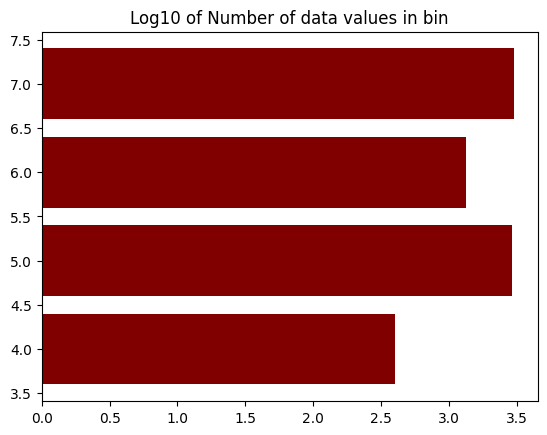

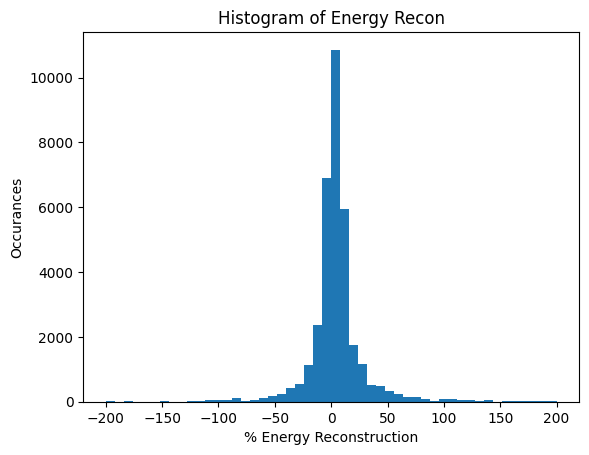

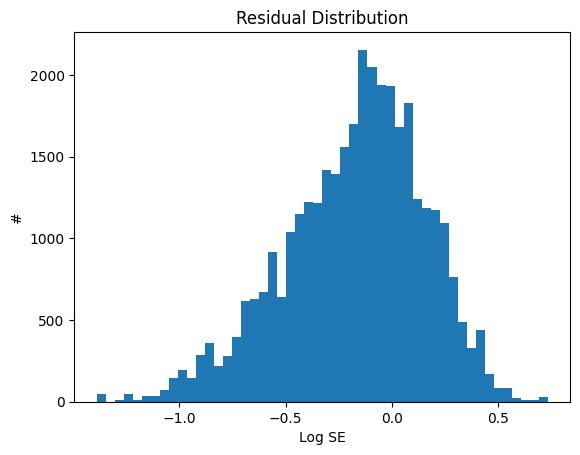

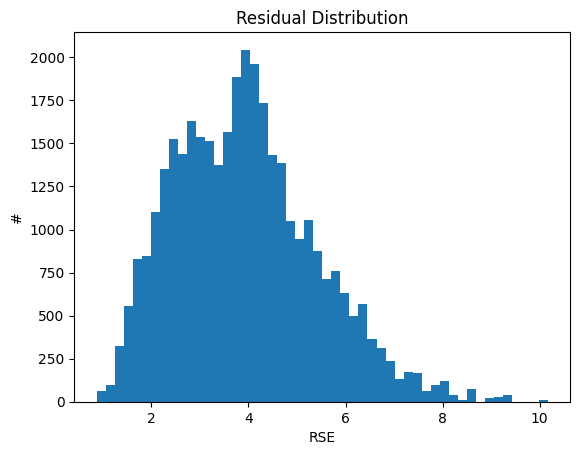

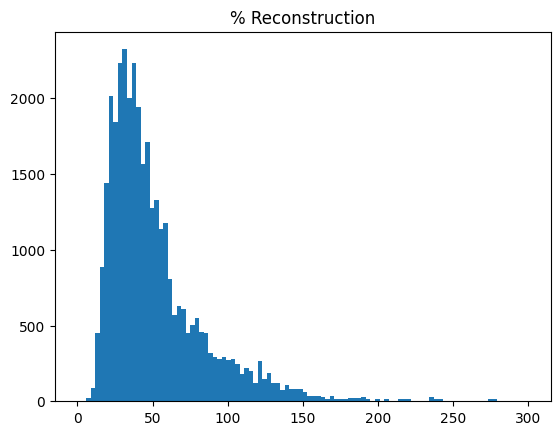

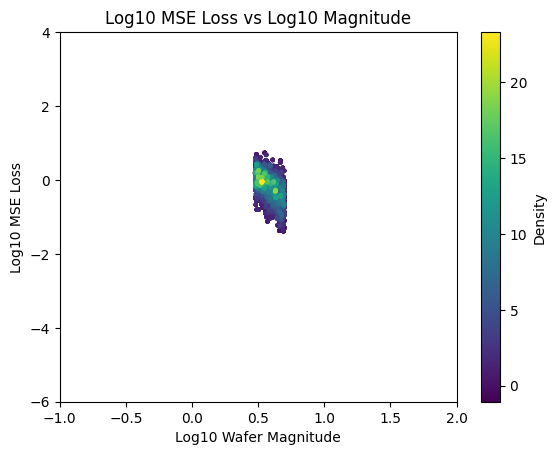

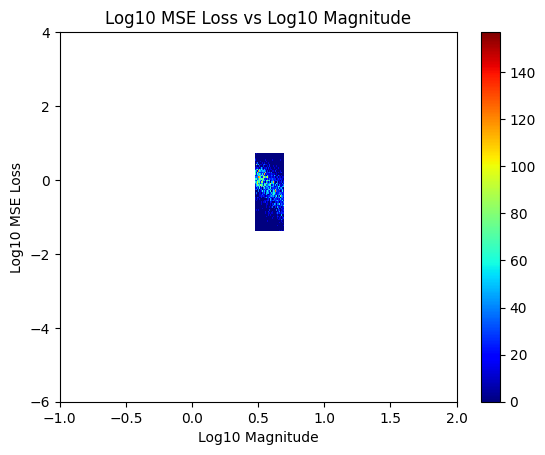

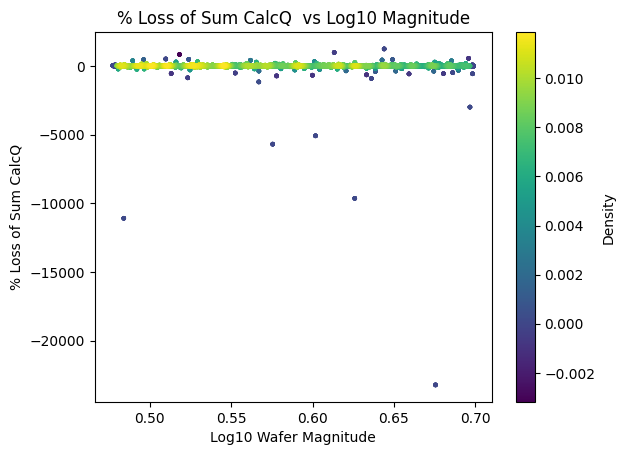

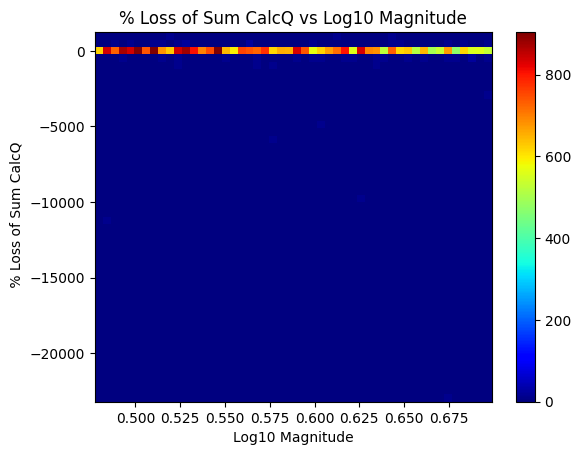

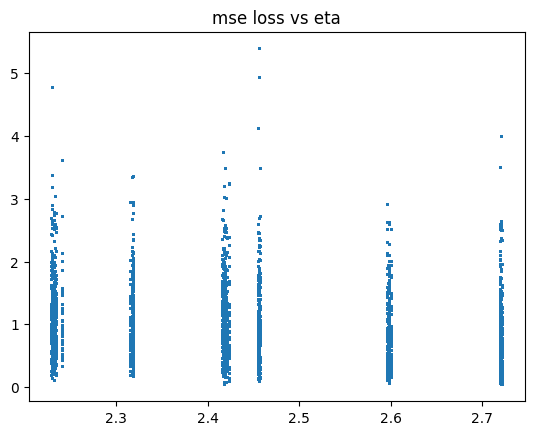

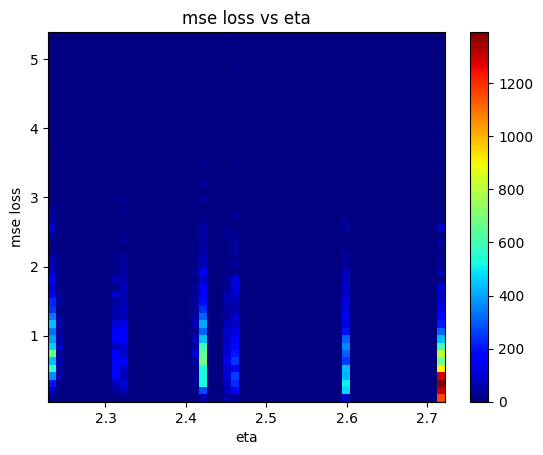

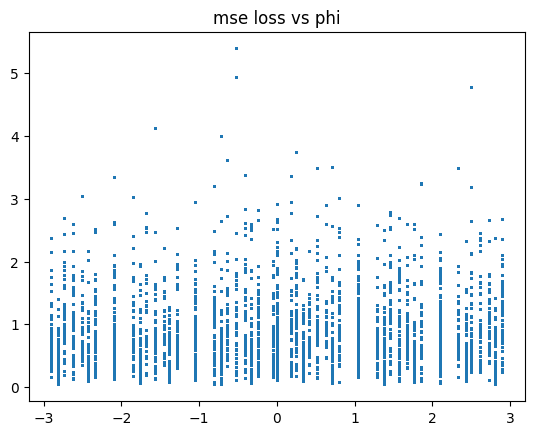

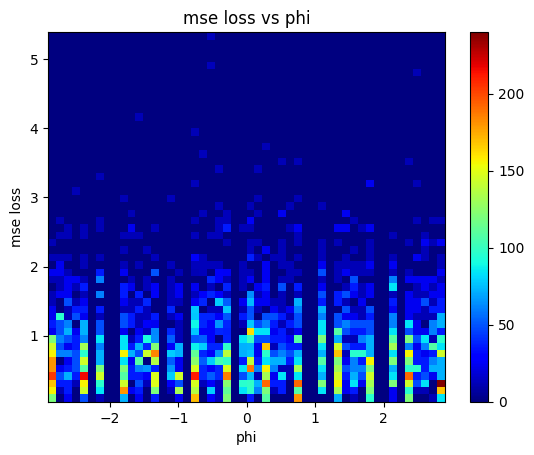

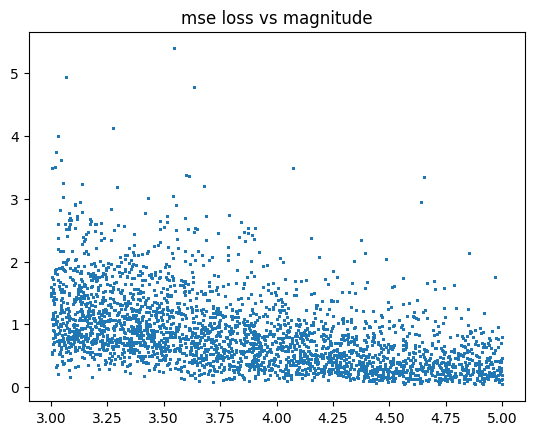

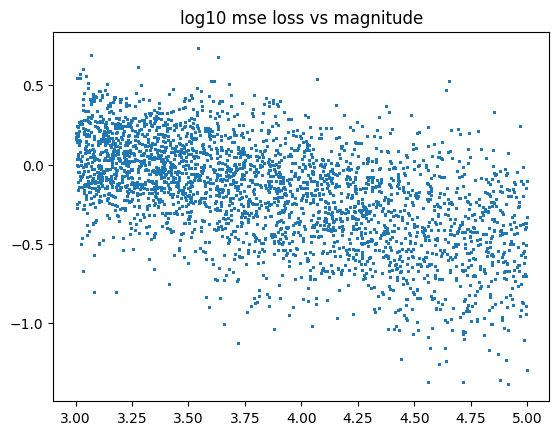

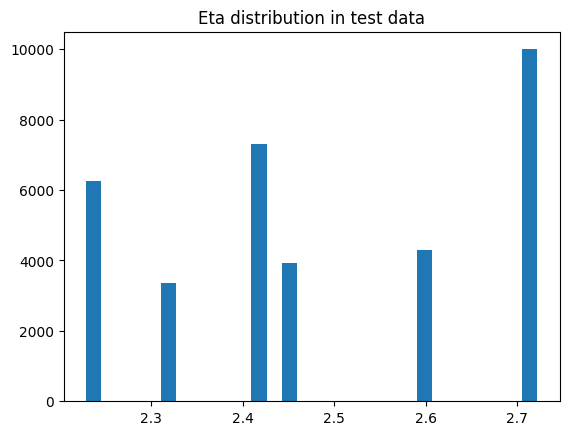

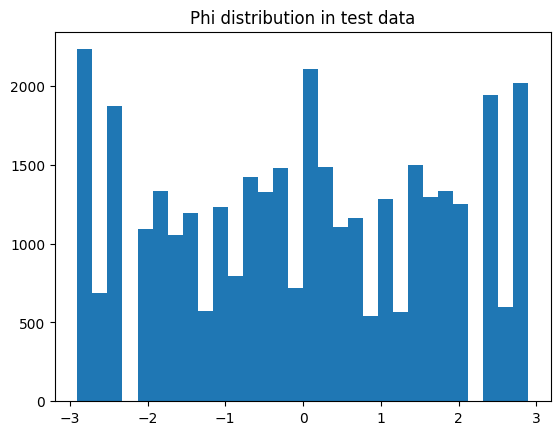

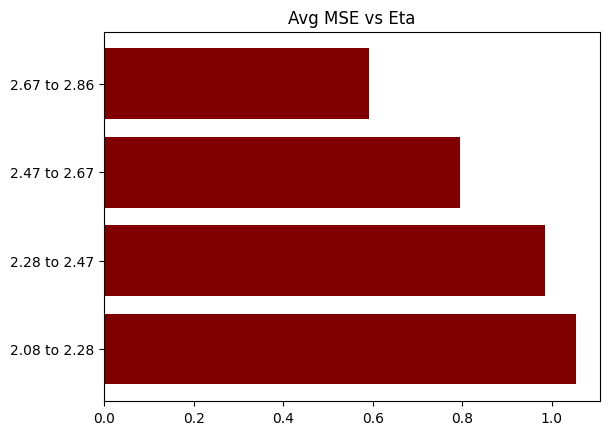

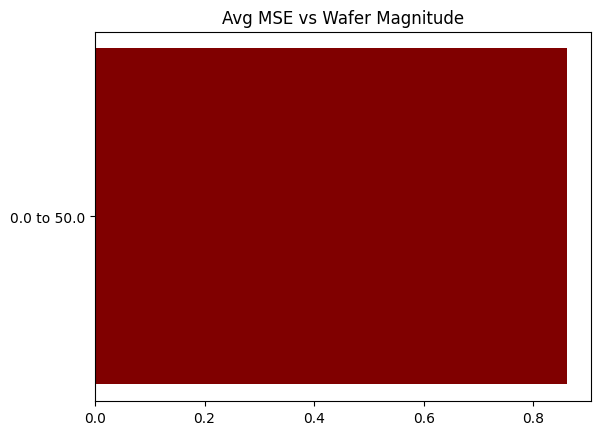

TRAINING MODEL m2
Epoch 0, lr 0.001
Epoch 0: Train 16.784381907708166, Test 13.662846565246582
Epoch 50, lr 0.00025
Epoch 50: Train 5.614642698710202, Test 4.827262878417969
Epoch 100, lr 0.000125
Epoch 100: Train 2.5624005360761064, Test 1.665389895439148
Epoch 150, lr 3.125e-05
Epoch 150: Train 1.9381011738121965, Test 1.01334810256958
MSE 0.030261244624853134
Median 0.0124178696423769
Standard Devitaion 0.05485071241855621
Average std error 0.6082358956336975
Average % Error of Energy Reconstruction 13.789673805236816


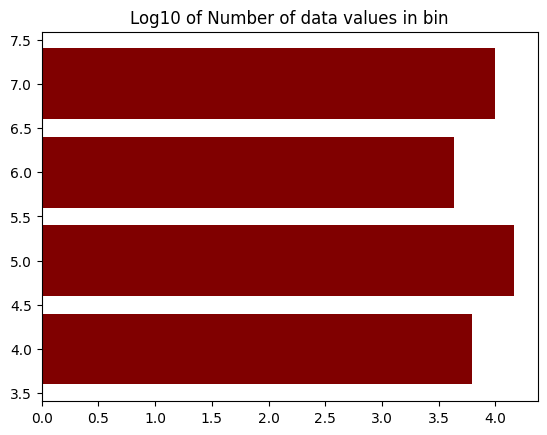

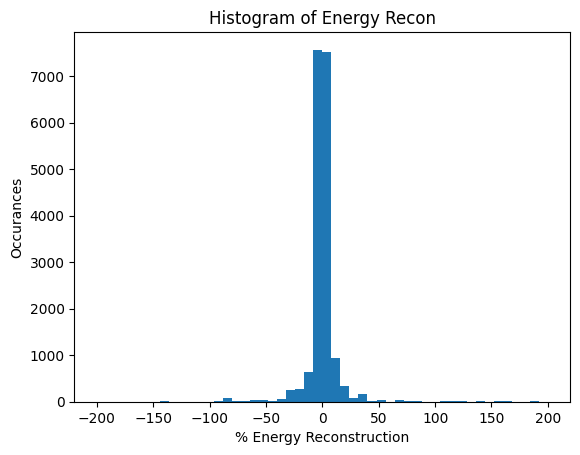

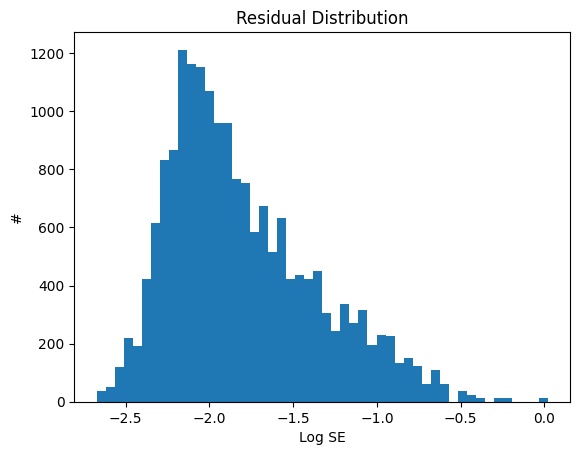

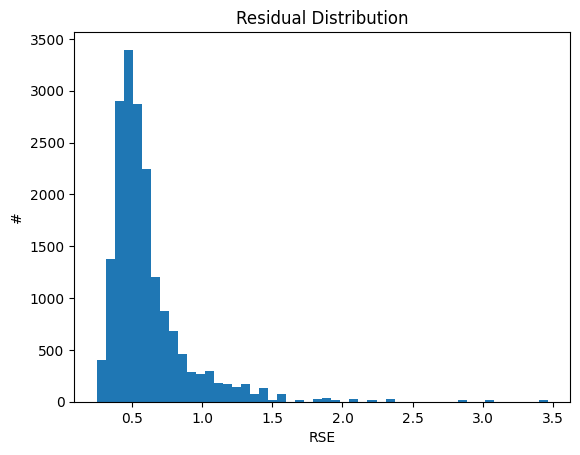

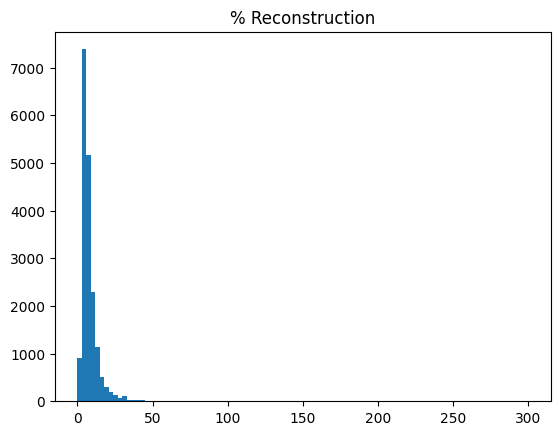

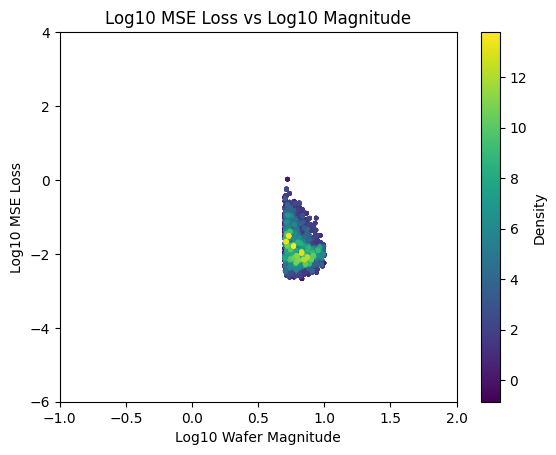

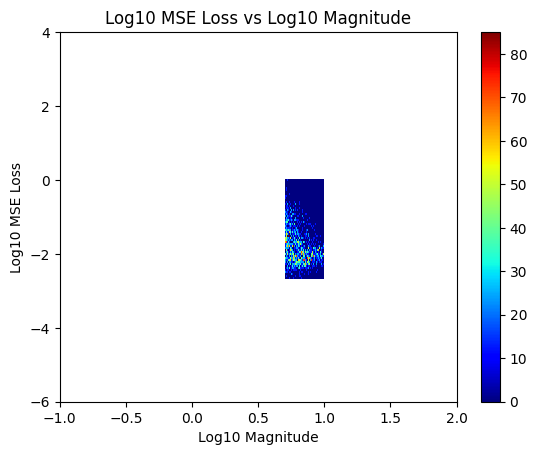

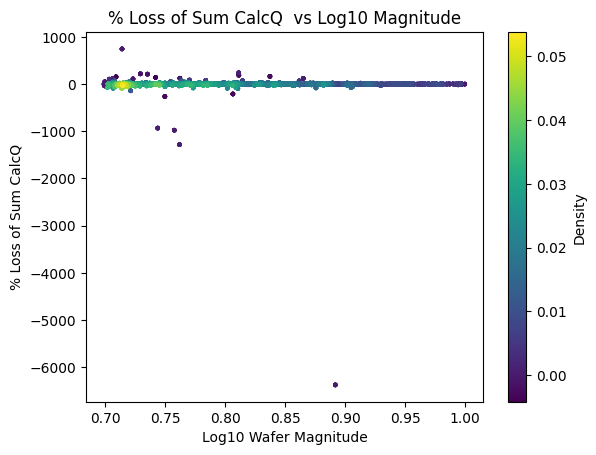

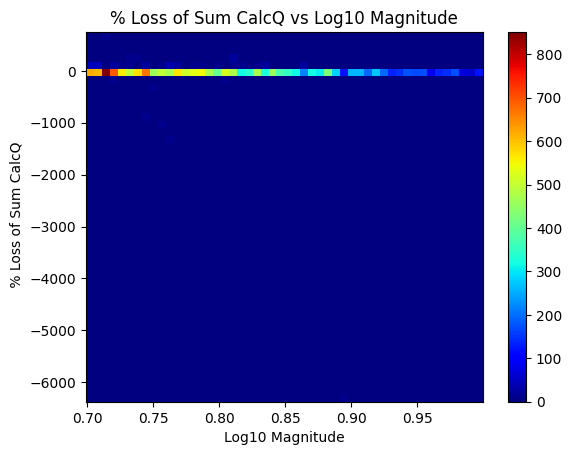

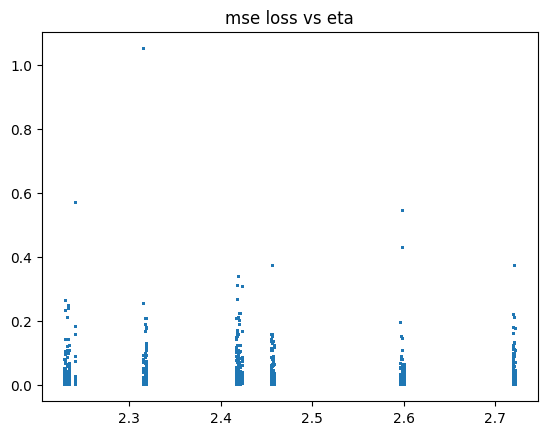

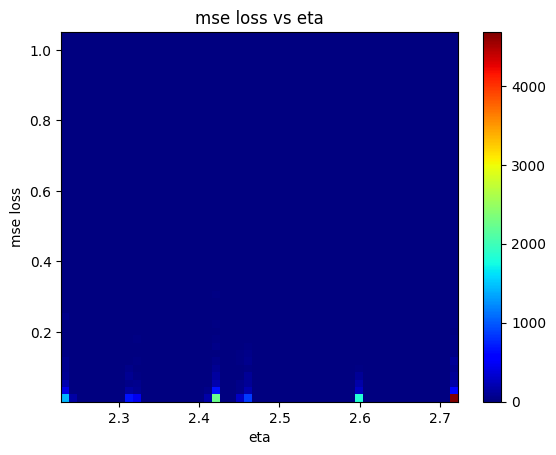

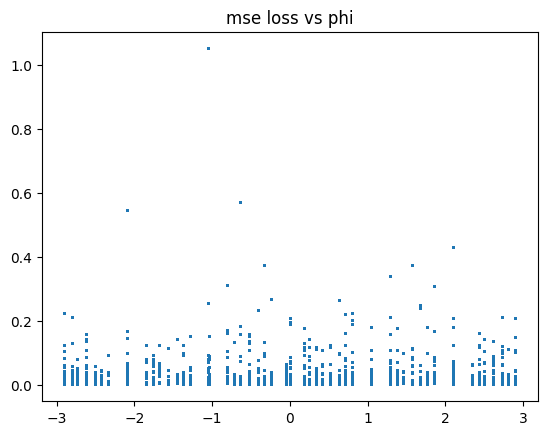

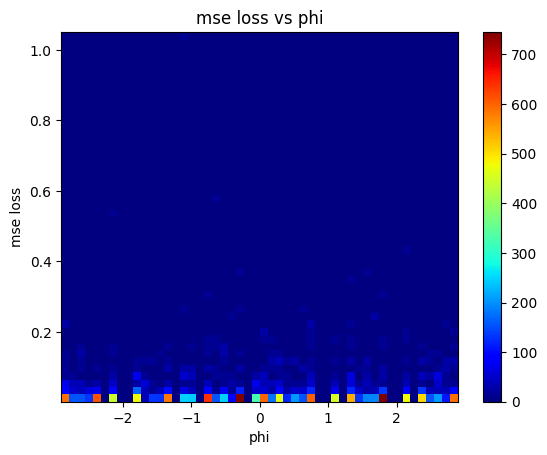

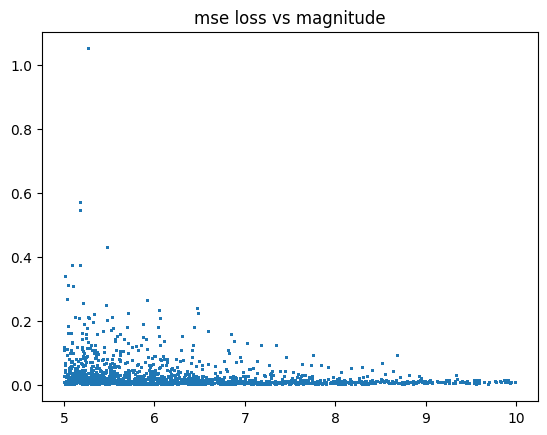

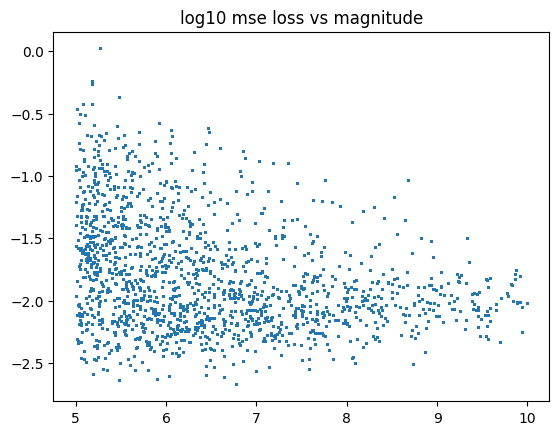

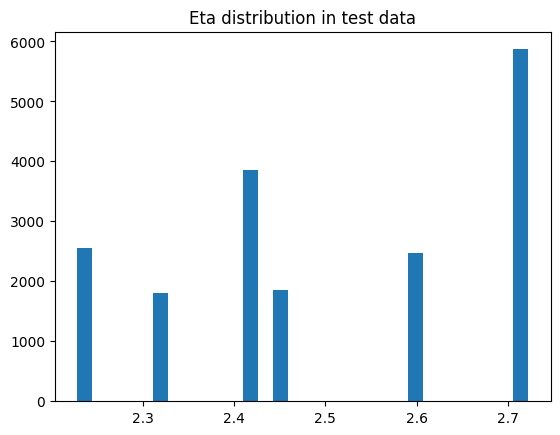

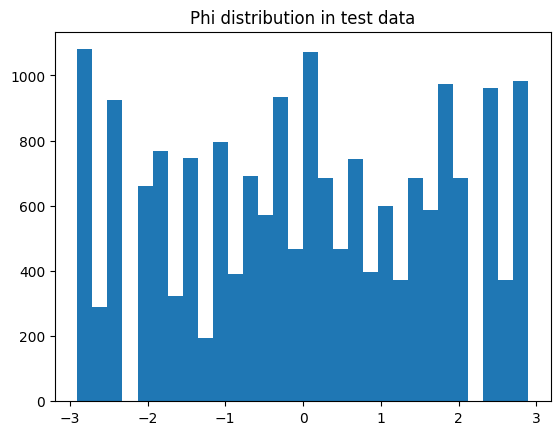

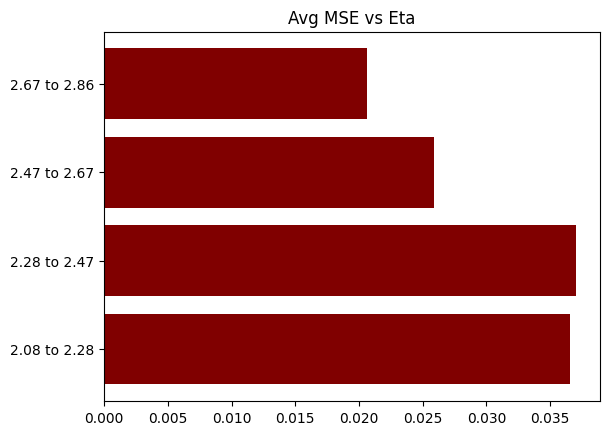

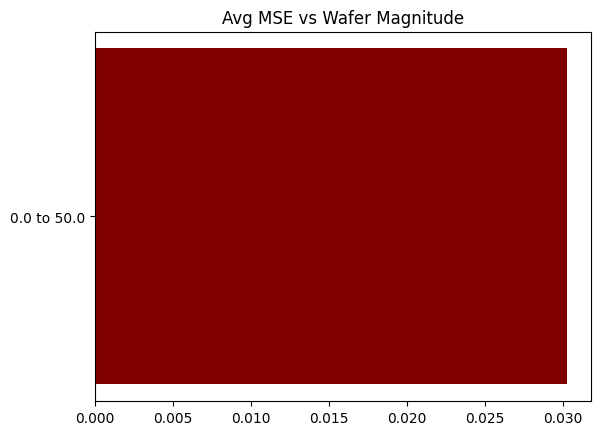

TRAINING MODEL outlier
Epoch 0, lr 0.001
Epoch 0: Train 62.930798608404366, Test 118.55068969726562
Epoch 50, lr 0.0005
Epoch 50: Train 40.86202195394842, Test 29.78417205810547
Epoch 100, lr 0.000125
Epoch 100: Train 11.177662980371188, Test 4.503881931304932
Epoch 150, lr 3.125e-05
Epoch 150: Train 2.5256412720278756, Test 0.5978037118911743
MSE 0.020802907645702362
Median 4.4650802010437474e-05
Standard Devitaion 0.1795365959405899
Average std error 0.1263618767261505
Average % Error of Energy Reconstruction 1.7254728078842163


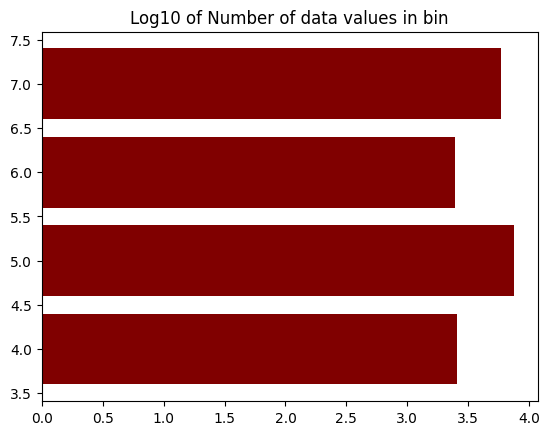

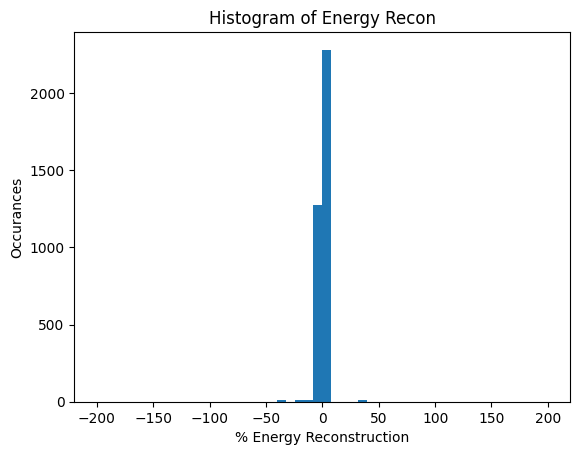

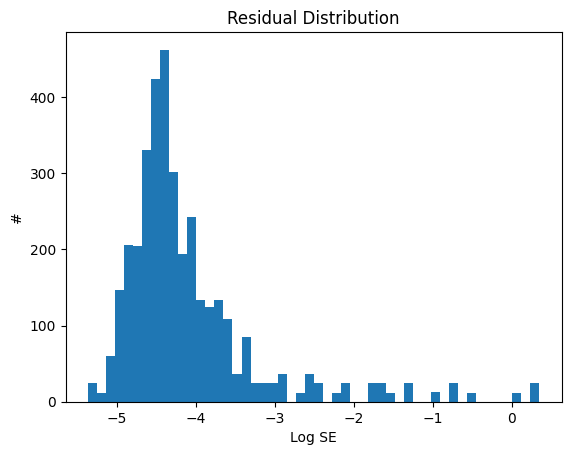

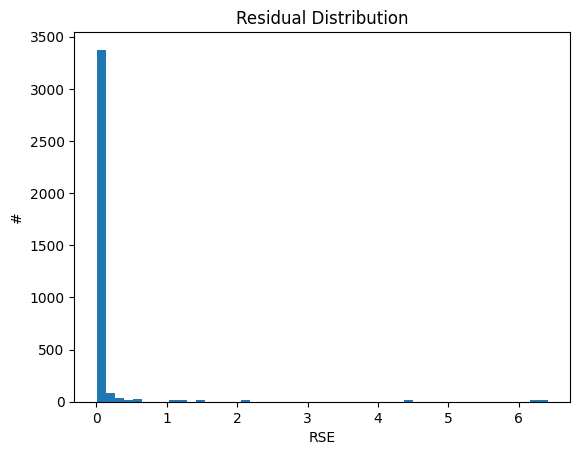

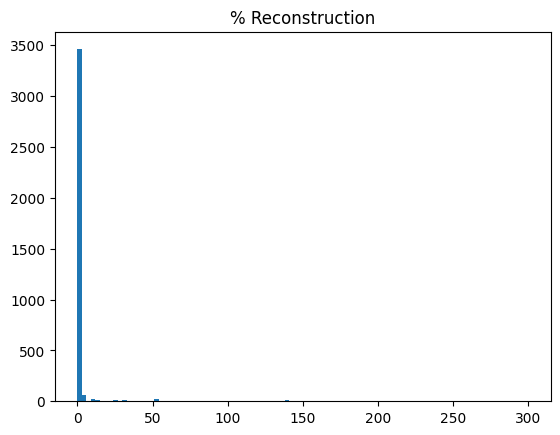

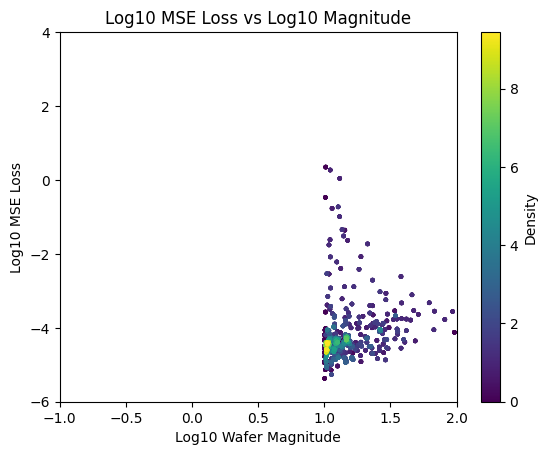

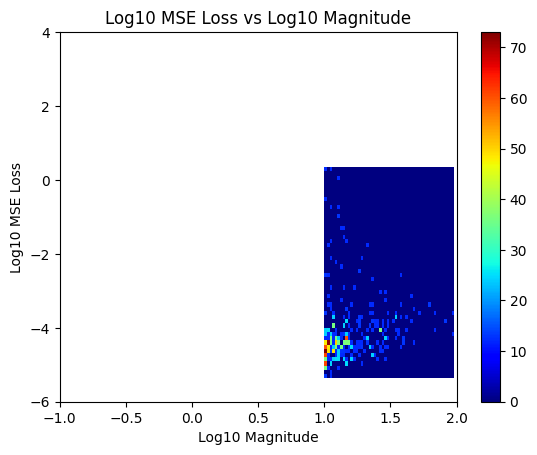

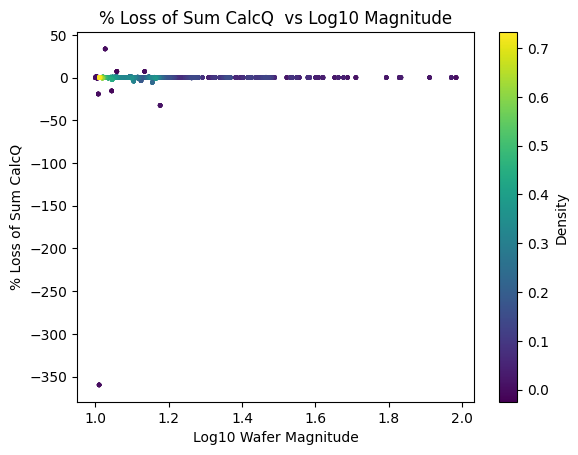

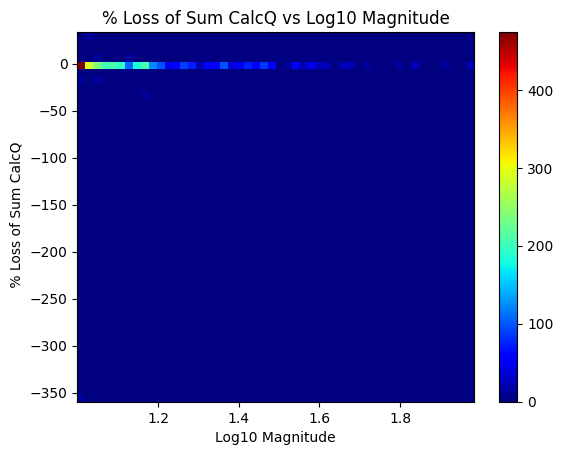

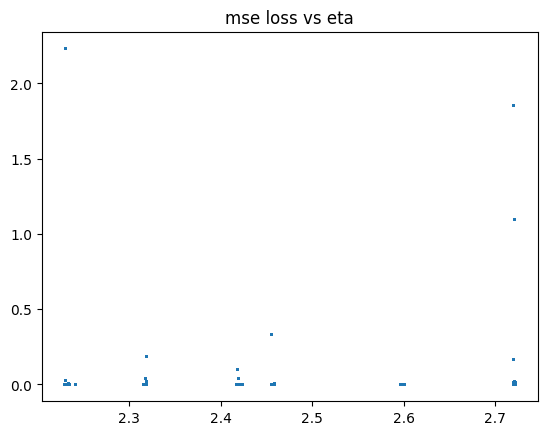

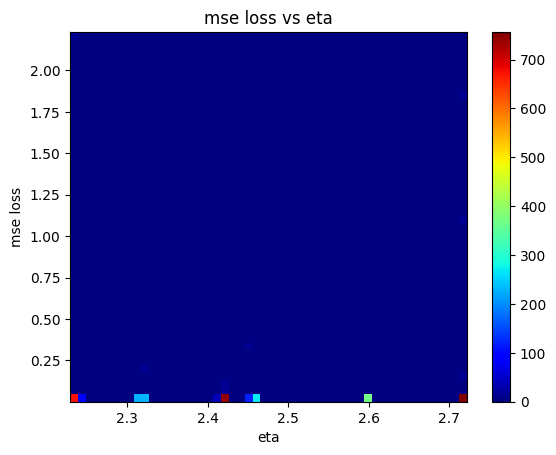

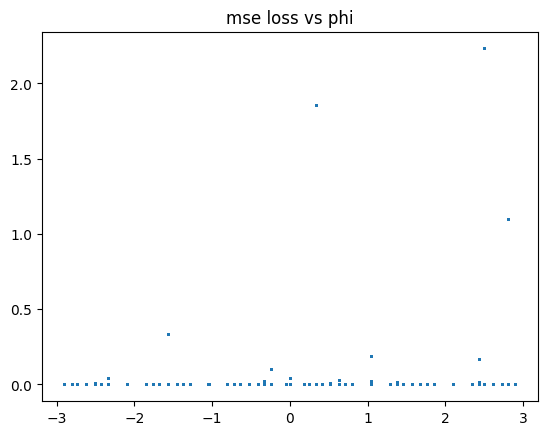

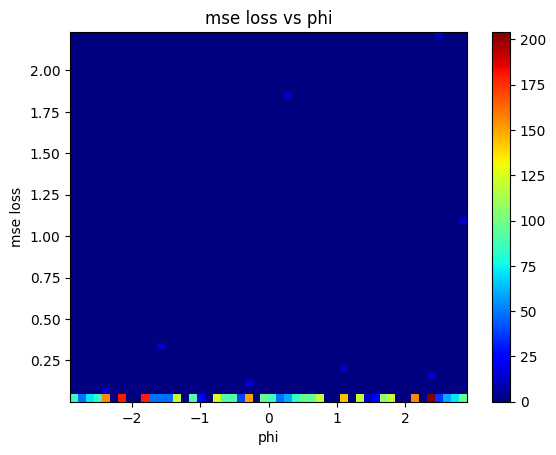

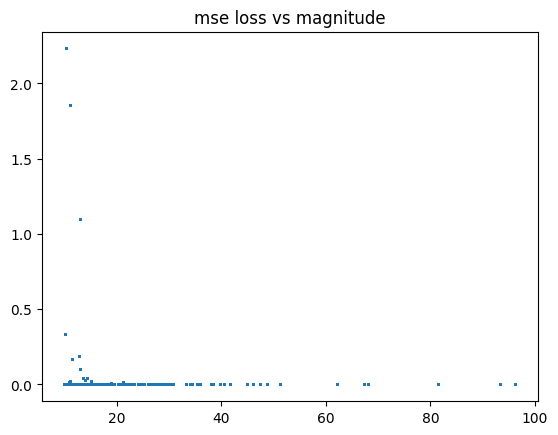

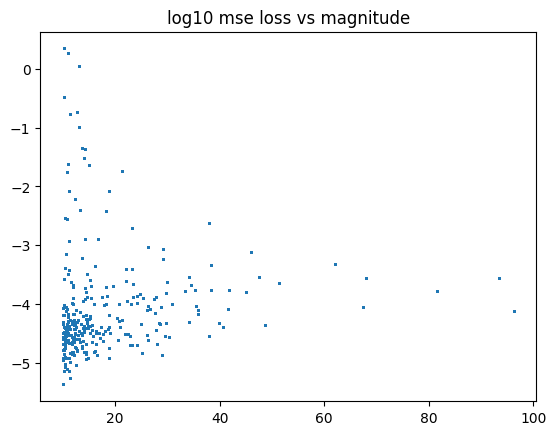

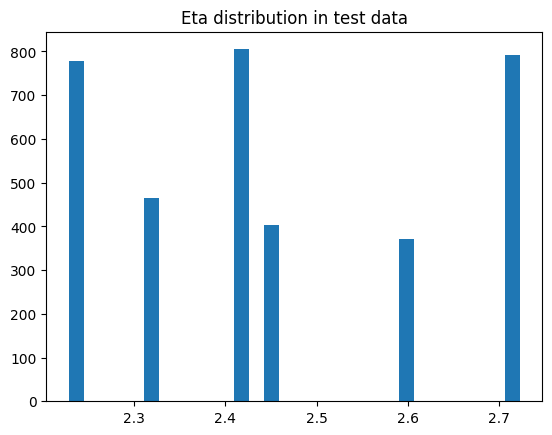

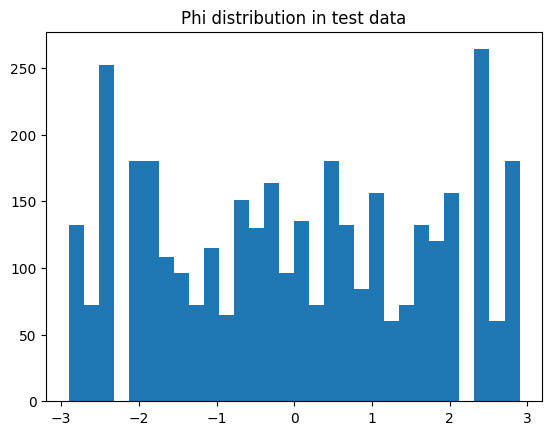

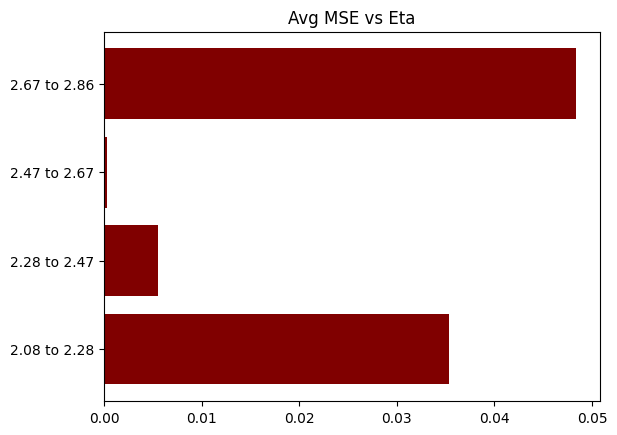

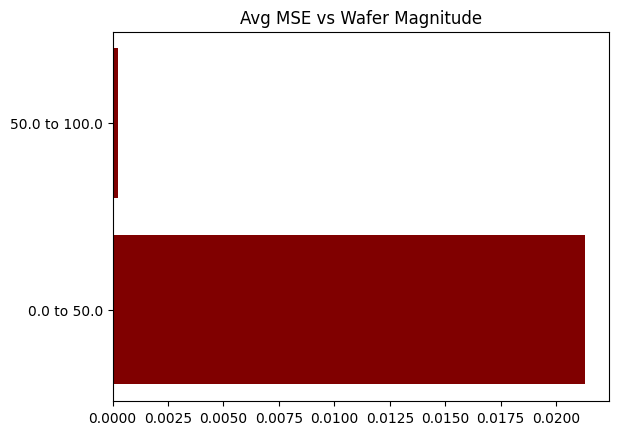

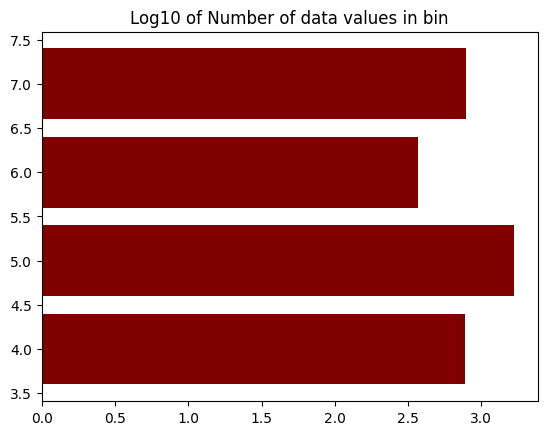

In [76]:
# train_models(data,'batch_4_models_tt_bar_norm_mean_0_var_1_sim_energy')

/uscms_data/d3/nswood/Notebooks/AE_Dev/models
mkdir: cannot create directory ‘batch_4_models_tt_bar_norm_mean_0_var_1_model_trainings’: File exists
/uscms_data/d3/nswood/Notebooks/AE_Dev
TRAINING MODEL low
Epoch 0, lr 0.0015
Epoch 0: Train 8.527148329920886, Test 6.449697971343994
Epoch 1, lr 0.0015
Epoch 1: Train 5.630881365334115, Test 5.128233432769775
Epoch 2, lr 0.0015
Epoch 2: Train 4.924338537890737, Test 4.6165771484375
Epoch 3, lr 0.0015
Epoch 3: Train 4.562257563195577, Test 4.225998878479004
Epoch 4, lr 0.0015
Epoch 4: Train 4.312976881352866, Test 4.207452297210693
Epoch 5, lr 0.0015
Epoch 5: Train 4.164622691201001, Test 3.9720511436462402
Epoch 6, lr 0.0015
Epoch 6: Train 4.03870088472599, Test 3.776003837585449
Epoch 7, lr 0.0015
Epoch 7: Train 3.953266349362164, Test 3.7548038959503174
Epoch 8, lr 0.0015
Epoch 8: Train 3.8922613388154566, Test 3.6844277381896973
Epoch 9, lr 0.0015
Epoch 9: Train 3.8359142085401023, Test 3.5197153091430664
Epoch 10, lr 0.0015
Epoch 10: T

Epoch 100, lr 0.0001875
Epoch 100: Train 0.8668638762540933, Test 0.5325328707695007
Epoch 101, lr 0.0001875
Epoch 101: Train 0.8684376348082612, Test 0.5336984395980835
Epoch 102, lr 0.0001875
Epoch 102: Train 0.8671011976352552, Test 0.5207289457321167
Epoch 103, lr 0.0001875
Epoch 103: Train 0.8697571324139106, Test 0.5370410680770874
Epoch 104, lr 0.0001875
Epoch 104: Train 0.8672562368395852, Test 0.5278030633926392
Epoch 105, lr 0.0001875
Epoch 105: Train 0.8680290918524672, Test 0.5371893644332886
Epoch 106, lr 9.375e-05
Epoch 106: Train 0.8659793085077914, Test 0.5152759552001953
Epoch 107, lr 9.375e-05
Epoch 107: Train 0.6788477825318895, Test 0.31246092915534973
Epoch 108, lr 9.375e-05
Epoch 108: Train 0.6651281671553123, Test 0.315927654504776
Epoch 109, lr 9.375e-05
Epoch 109: Train 0.6595505471273166, Test 0.3064306080341339
Epoch 110, lr 9.375e-05
Epoch 110: Train 0.6597758448705441, Test 0.30643555521965027
Epoch 111, lr 9.375e-05
Epoch 111: Train 0.6562777497419496, Tes

Epoch 195, lr 2.34375e-05
Epoch 195: Train 0.4628033394948011, Test 0.10135205090045929
Epoch 196, lr 2.34375e-05
Epoch 196: Train 0.46255719153801117, Test 0.09816178679466248
Epoch 197, lr 2.34375e-05
Epoch 197: Train 0.4622636750976487, Test 0.10000960528850555
Epoch 198, lr 2.34375e-05
Epoch 198: Train 0.46257096978767615, Test 0.09886034578084946
Epoch 199, lr 2.34375e-05
Epoch 199: Train 0.4625044244273407, Test 0.10093408823013306
MSE 0.002202417701482773
Median 0.00019838663865812123
Standard Devitaion 0.007222932763397694
Average std error 0.09755490720272064
Average % Error of Energy Reconstruction 0.8162342309951782


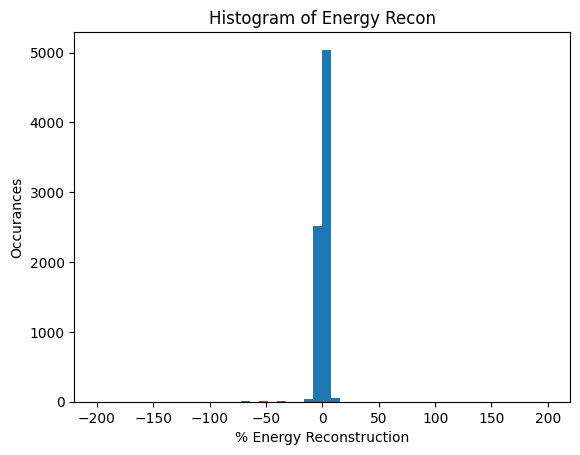

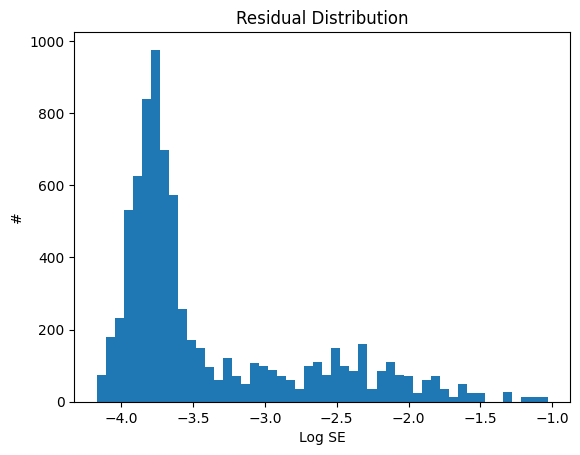

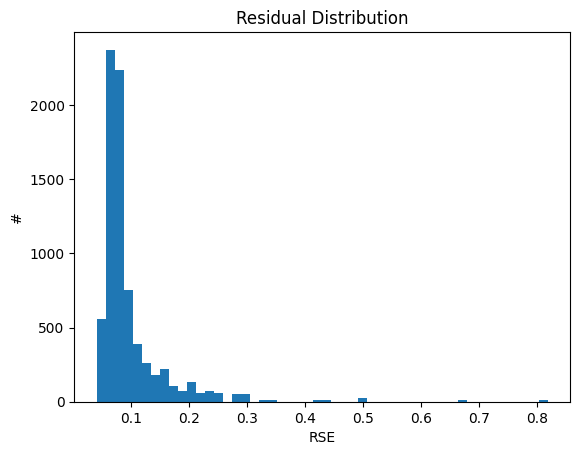

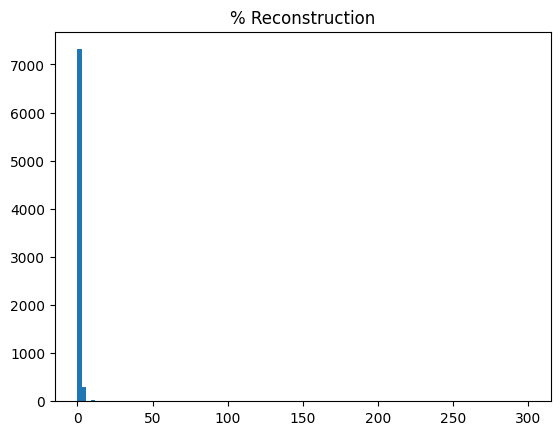

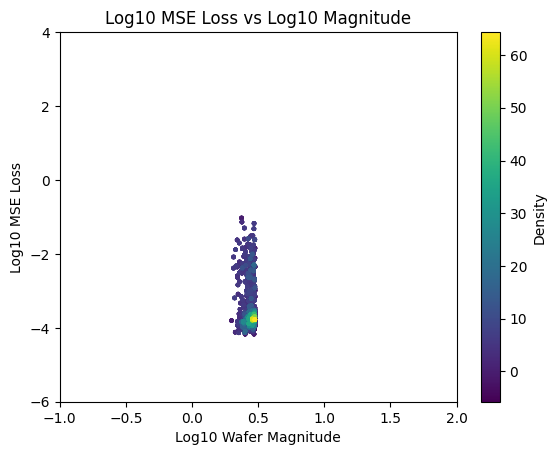

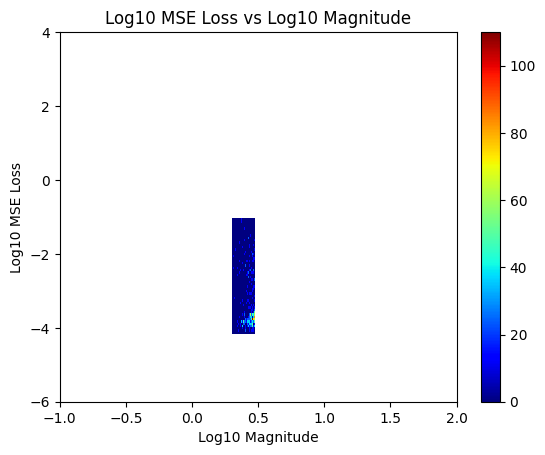

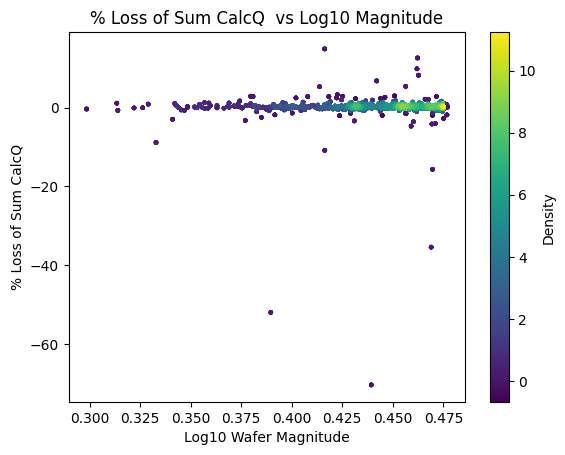

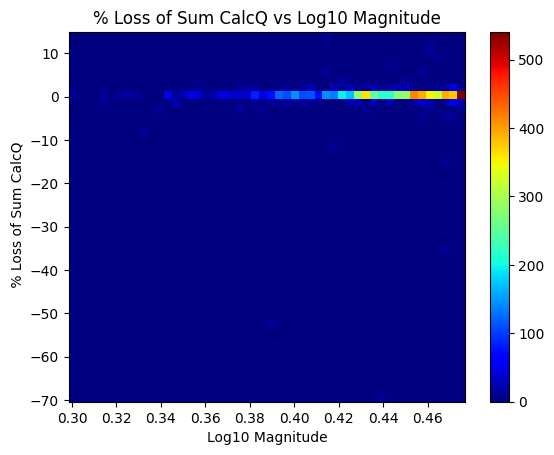

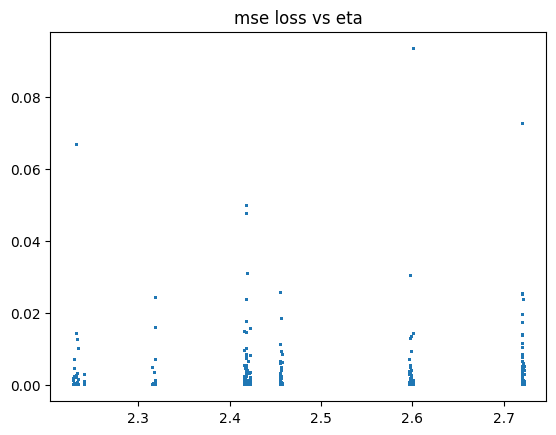

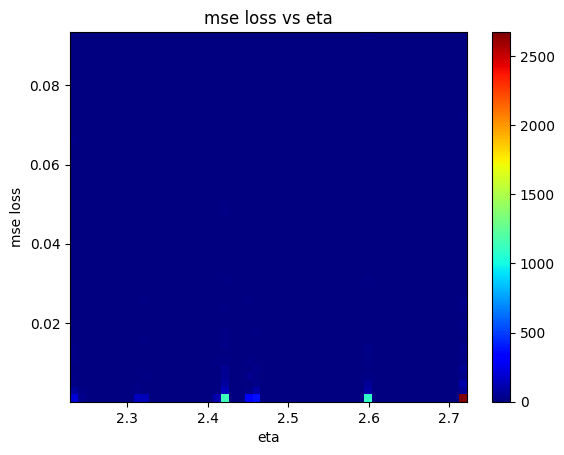

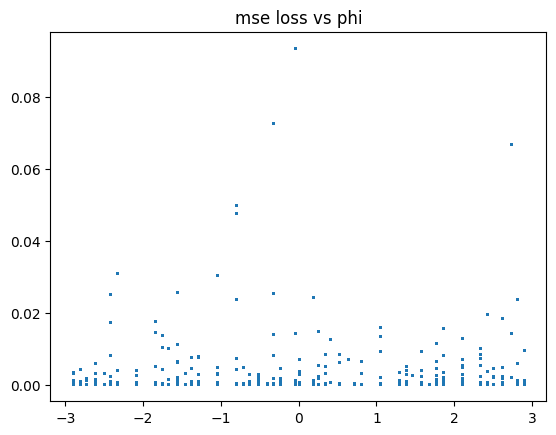

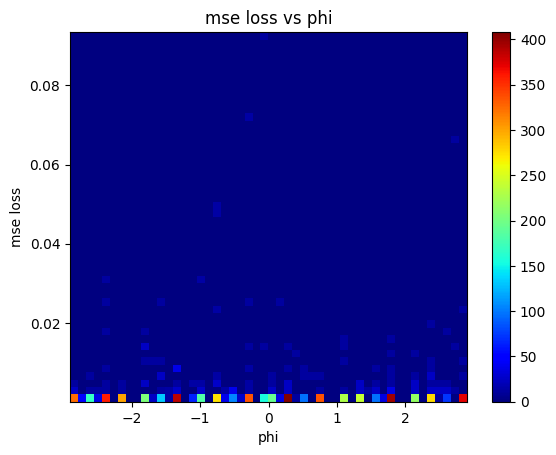

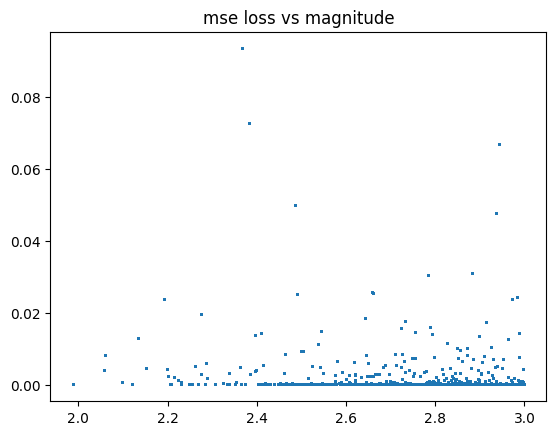

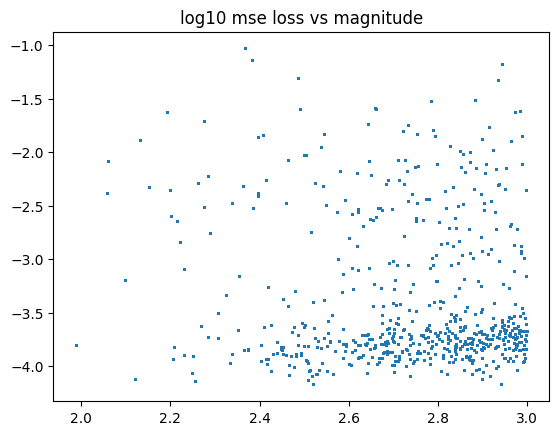

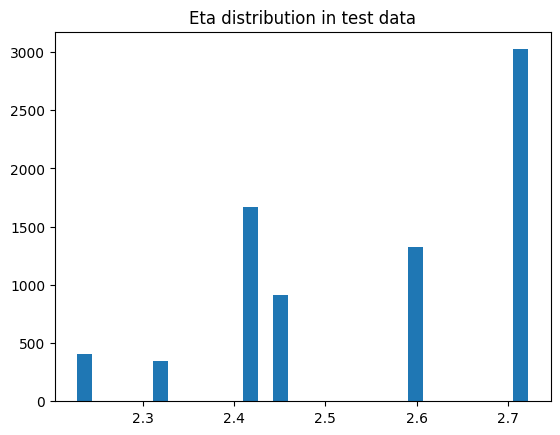

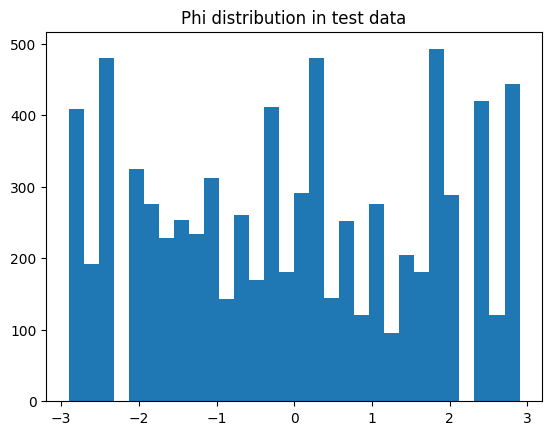

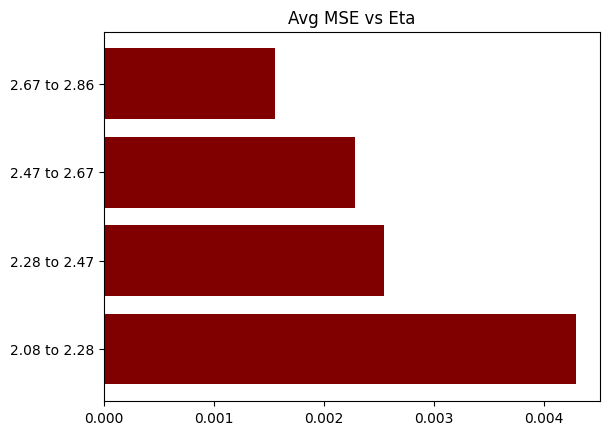

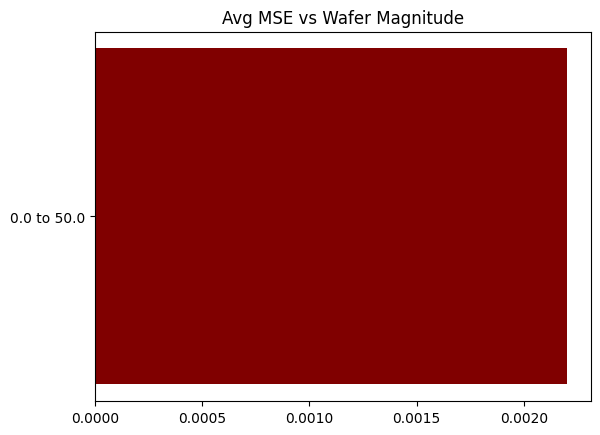

TRAINING MODEL m1
Epoch 0, lr 0.0015
Epoch 0: Train 18.647349909892664, Test 17.829111099243164
Epoch 1, lr 0.0015
Epoch 1: Train 17.75571046614812, Test 17.259103775024414
Epoch 2, lr 0.0015
Epoch 2: Train 17.251101282472362, Test 16.86378288269043
Epoch 3, lr 0.0015
Epoch 3: Train 16.872054953110236, Test 16.590621948242188
Epoch 4, lr 0.0015
Epoch 4: Train 16.58202136420289, Test 16.180442810058594
Epoch 5, lr 0.0015
Epoch 5: Train 16.36907848374413, Test 16.091148376464844
Epoch 6, lr 0.0015
Epoch 6: Train 16.190510484596867, Test 15.71484375
Epoch 7, lr 0.0015
Epoch 7: Train 16.03512858582356, Test 15.662704467773438
Epoch 8, lr 0.0015
Epoch 8: Train 15.917684951105459, Test 15.602935791015625
Epoch 9, lr 0.0015
Epoch 9: Train 15.82483725225157, Test 15.532075881958008
Epoch 10, lr 0.0015
Epoch 10: Train 15.736590050609427, Test 15.568918228149414
Epoch 11, lr 0.0015
Epoch 11: Train 15.688155099821014, Test 15.383543014526367
Epoch 12, lr 0.0015
Epoch 12: Train 15.61673864888967, 

Epoch 103, lr 0.000375
Epoch 103: Train 9.800106223619041, Test 9.471549034118652
Epoch 104, lr 0.000375
Epoch 104: Train 9.786710395670724, Test 9.443816184997559
Epoch 105, lr 0.000375
Epoch 105: Train 9.773819589843507, Test 9.434072494506836
Epoch 106, lr 0.000375
Epoch 106: Train 9.762659265693985, Test 9.46289348602295
Epoch 107, lr 0.000375
Epoch 107: Train 9.755058400098733, Test 9.439481735229492
Epoch 108, lr 0.000375
Epoch 108: Train 9.74787722868556, Test 9.396469116210938
Epoch 109, lr 0.000375
Epoch 109: Train 9.738717014381844, Test 9.400186538696289
Epoch 110, lr 0.000375
Epoch 110: Train 9.733954954477595, Test 9.389453887939453
Epoch 111, lr 0.000375
Epoch 111: Train 9.725765703838432, Test 9.378393173217773
Epoch 112, lr 0.000375
Epoch 112: Train 9.72332883401951, Test 9.374042510986328
Epoch 113, lr 0.000375
Epoch 113: Train 9.715354941027178, Test 9.341362953186035
Epoch 114, lr 0.000375
Epoch 114: Train 9.708122252909885, Test 9.372800827026367
Epoch 115, lr 0.000

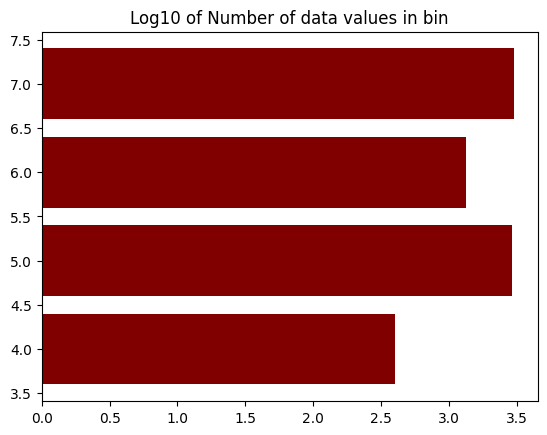

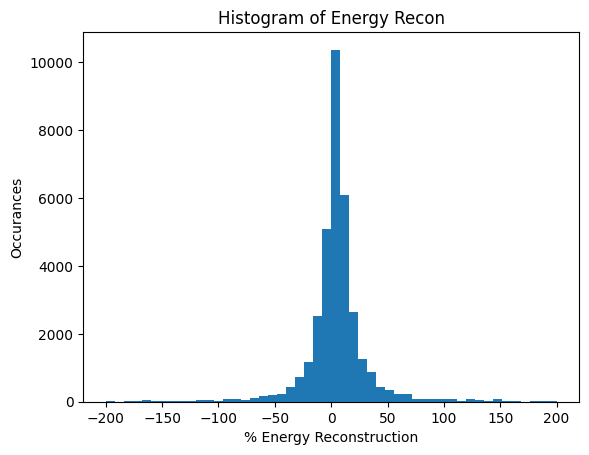

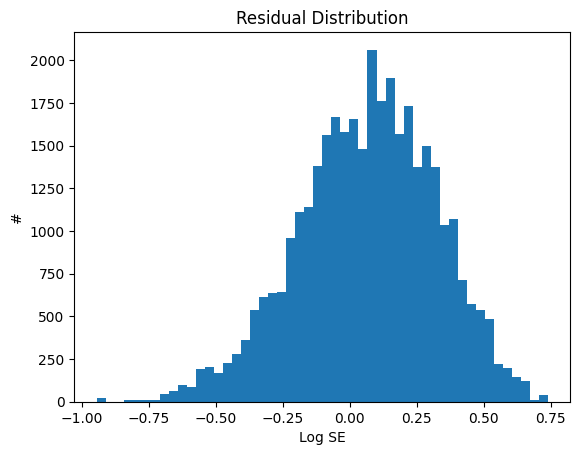

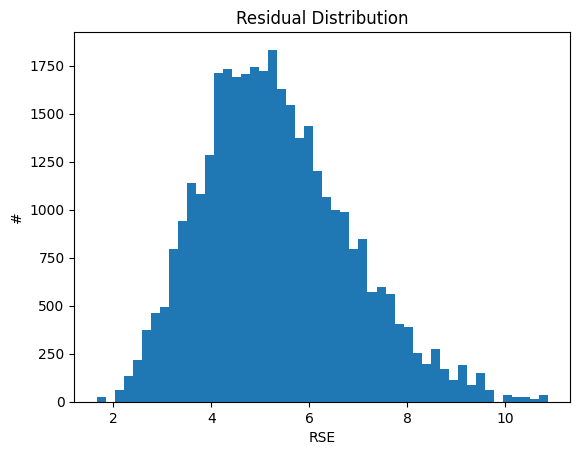

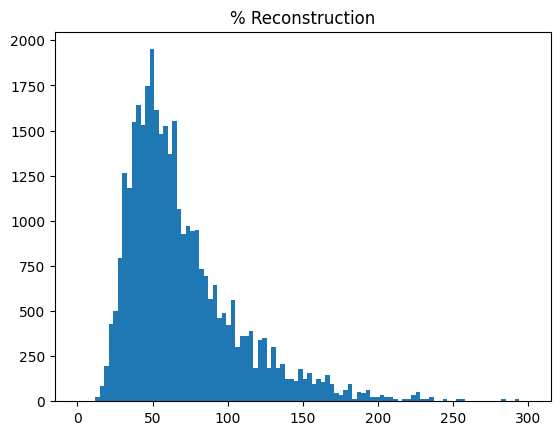

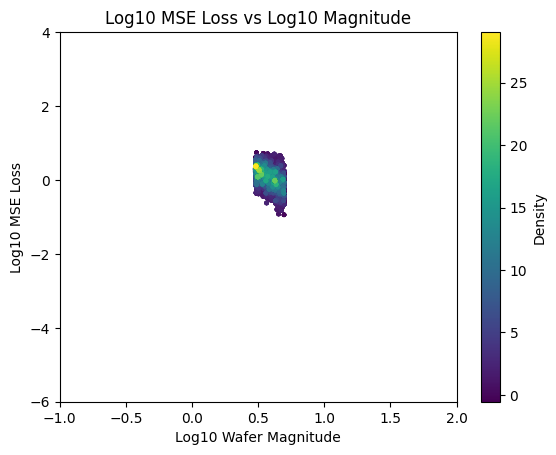

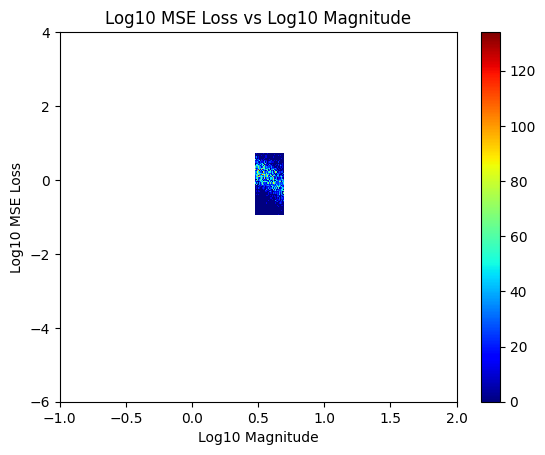

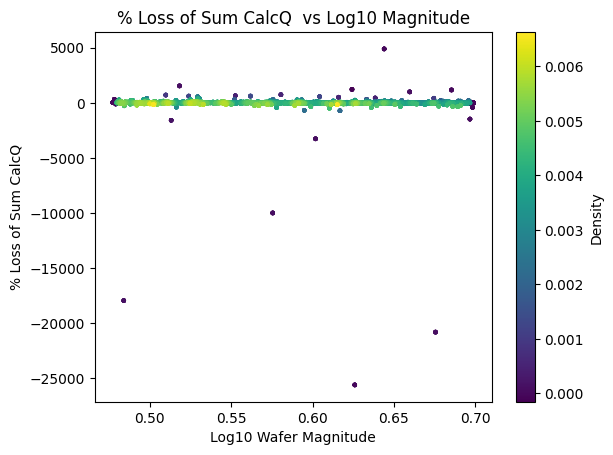

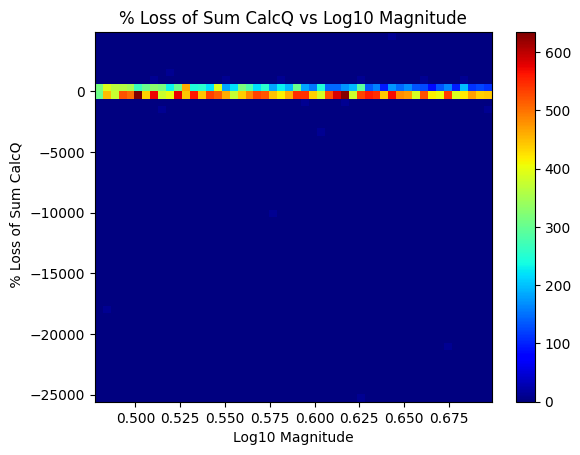

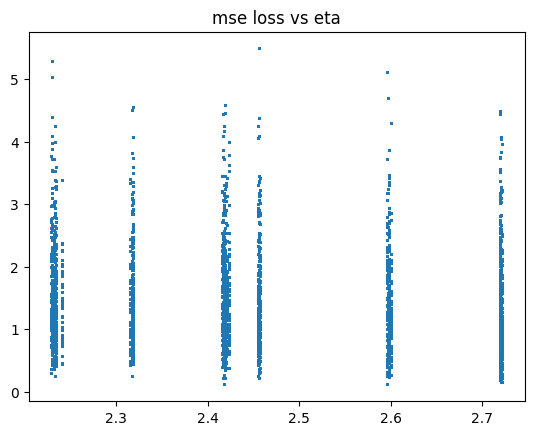

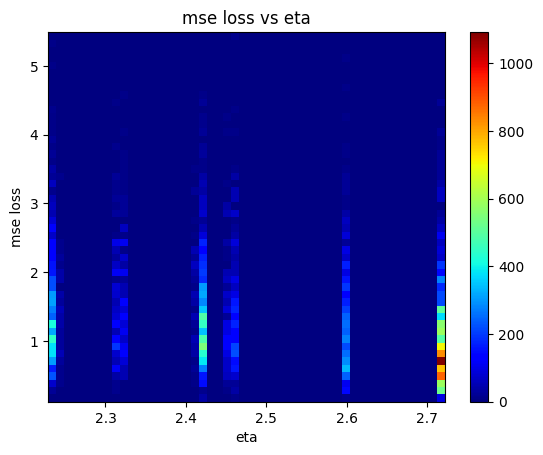

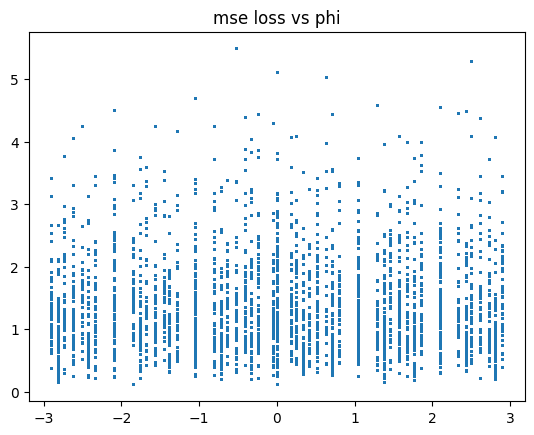

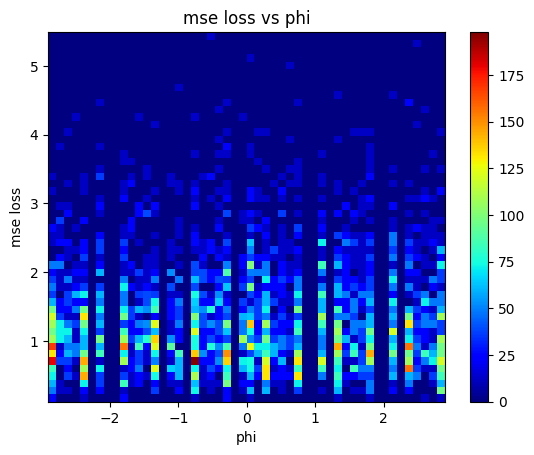

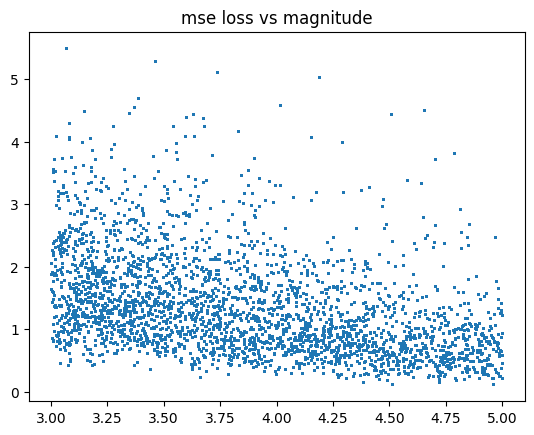

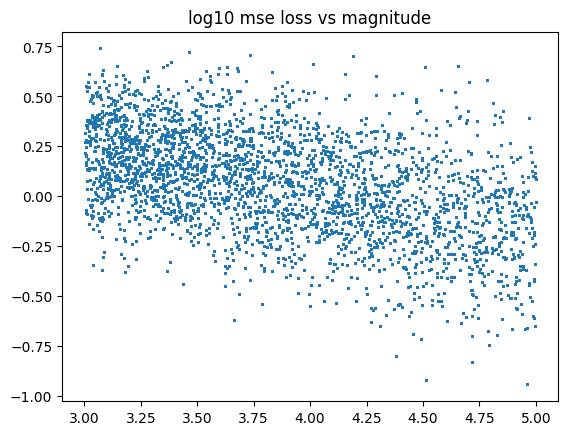

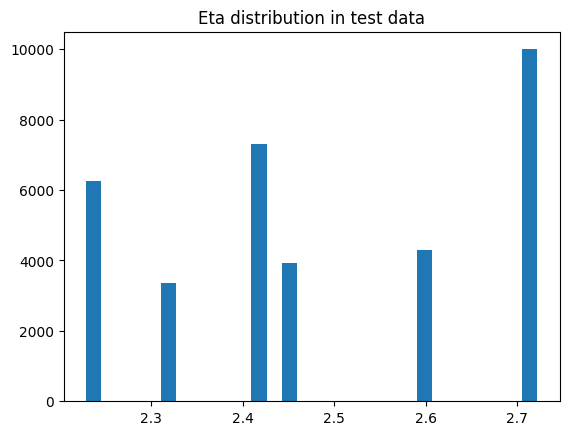

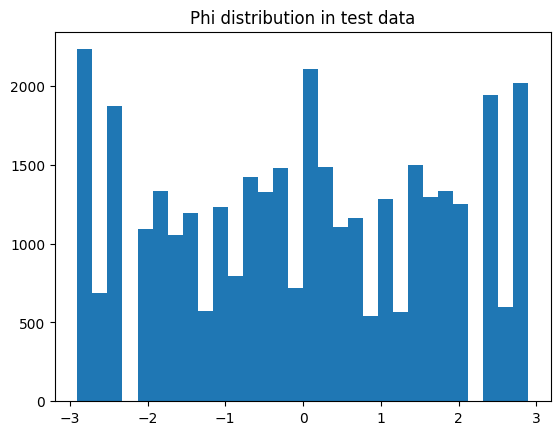

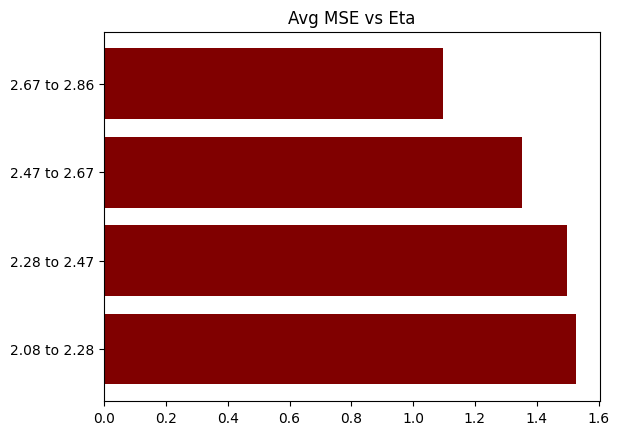

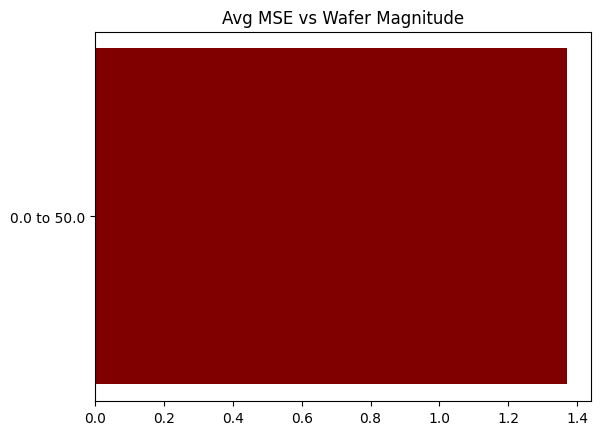

TRAINING MODEL m2
Epoch 0, lr 0.0015
Epoch 0: Train 20.021579210509476, Test 17.043075561523438
Epoch 1, lr 0.0015
Epoch 1: Train 16.291220693612523, Test 14.541954040527344
Epoch 2, lr 0.0015
Epoch 2: Train 15.101005604188254, Test 14.162729263305664
Epoch 3, lr 0.0015
Epoch 3: Train 14.406534192519636, Test 13.841135025024414
Epoch 4, lr 0.0015
Epoch 4: Train 13.927806465013033, Test 12.906909942626953
Epoch 5, lr 0.0015
Epoch 5: Train 13.551397177038606, Test 12.504488945007324
Epoch 6, lr 0.0015
Epoch 6: Train 13.319283496089867, Test 12.659536361694336
Epoch 7, lr 0.0015
Epoch 7: Train 13.074039599489012, Test 12.550877571105957
Epoch 8, lr 0.0015
Epoch 8: Train 12.985763338200615, Test 12.20692253112793
Epoch 9, lr 0.0015
Epoch 9: Train 12.799174542220797, Test 12.132881164550781
Epoch 10, lr 0.0015
Epoch 10: Train 12.683841757252623, Test 11.62755012512207
Epoch 11, lr 0.0015
Epoch 11: Train 12.523339736006642, Test 11.754129409790039
Epoch 12, lr 0.0015
Epoch 12: Train 12.46861

Epoch 103, lr 0.0001875
Epoch 103: Train 3.105032545191641, Test 2.1685028076171875
Epoch 104, lr 0.0001875
Epoch 104: Train 3.100823093370627, Test 2.1219921112060547
Epoch 105, lr 0.0001875
Epoch 105: Train 3.0987181084756634, Test 2.1515274047851562
Epoch 106, lr 0.0001875
Epoch 106: Train 3.0968767020538563, Test 2.175280809402466
Epoch 107, lr 0.0001875
Epoch 107: Train 3.0951301916258327, Test 2.1668953895568848
Epoch 108, lr 0.0001875
Epoch 108: Train 3.0933426576109637, Test 2.143702983856201
Epoch 109, lr 0.0001875
Epoch 109: Train 3.09253117225249, Test 2.158040761947632
Epoch 110, lr 0.0001875
Epoch 110: Train 3.0854532650712185, Test 2.1305031776428223
Epoch 111, lr 0.0001875
Epoch 111: Train 3.0856978989739456, Test 2.1640396118164062
Epoch 112, lr 0.0001875
Epoch 112: Train 3.089526423243166, Test 2.1234774589538574
Epoch 113, lr 0.0001875
Epoch 113: Train 3.079184341794662, Test 2.1379051208496094
Epoch 114, lr 0.0001875
Epoch 114: Train 3.0835332523472134, Test 2.103350

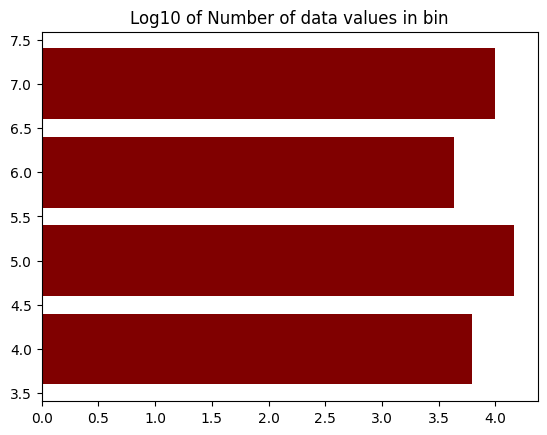

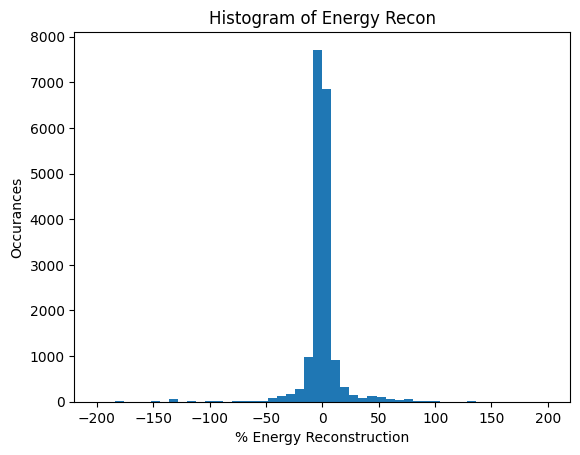

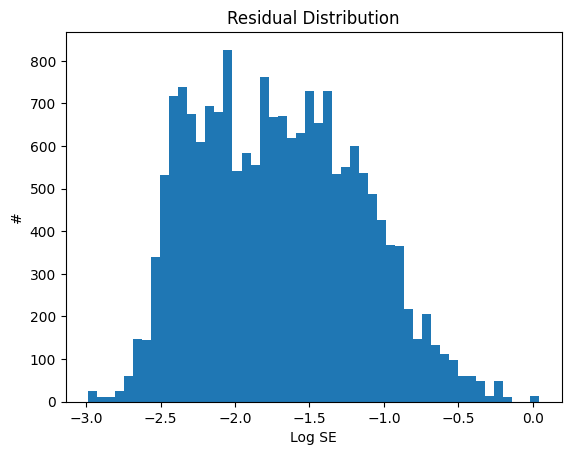

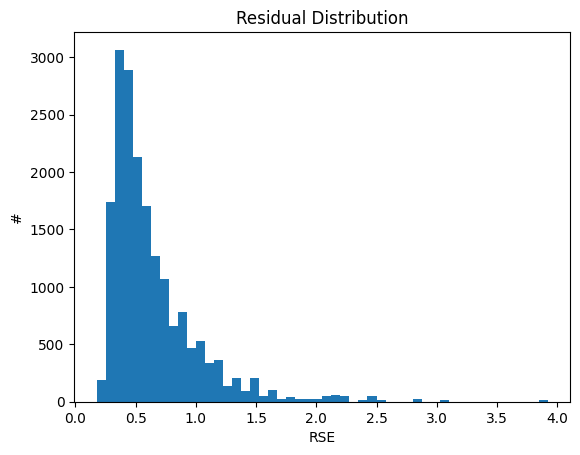

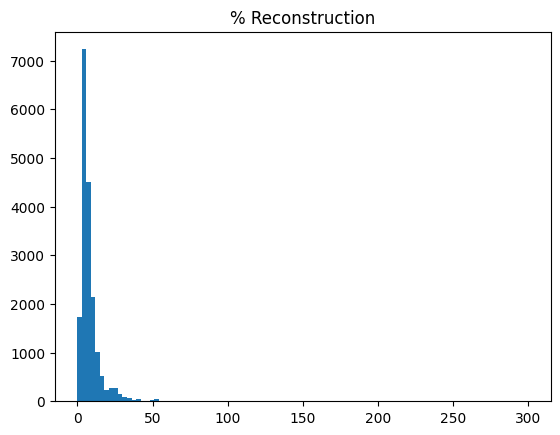

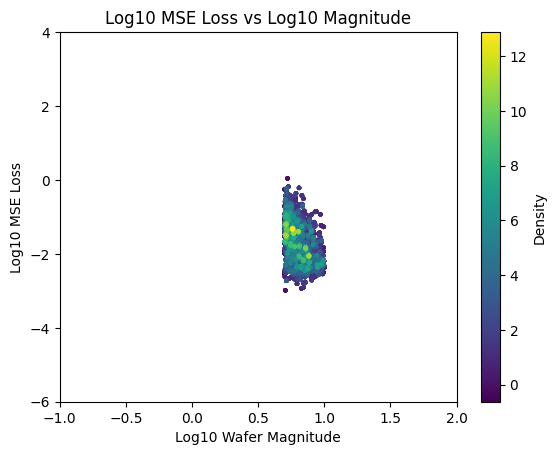

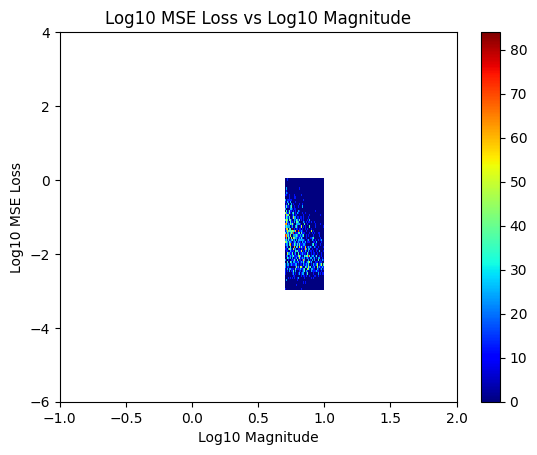

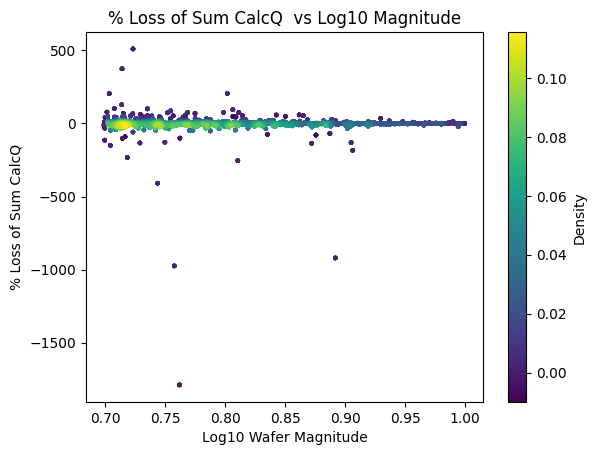

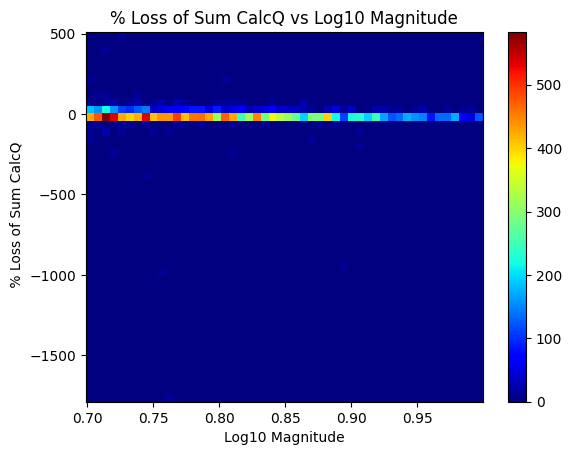

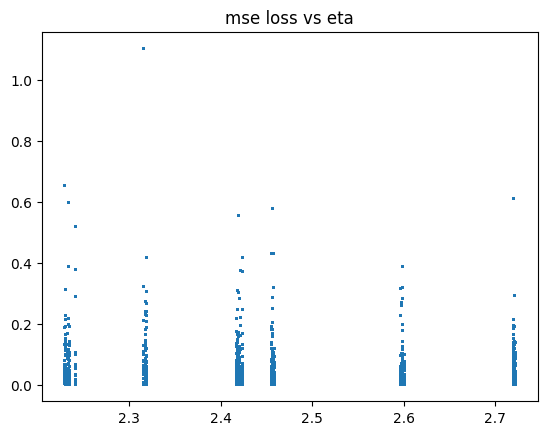

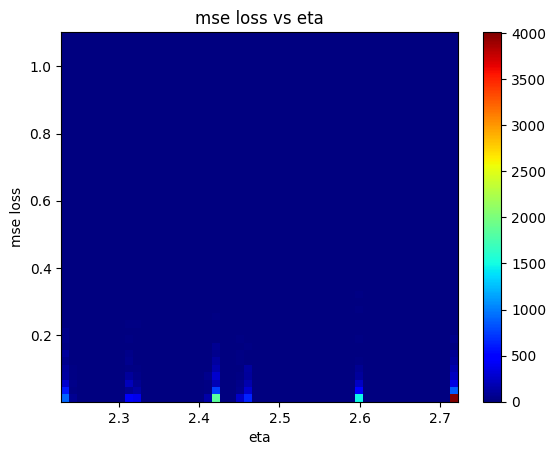

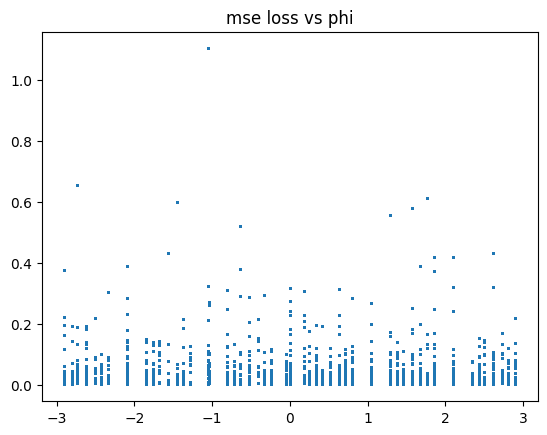

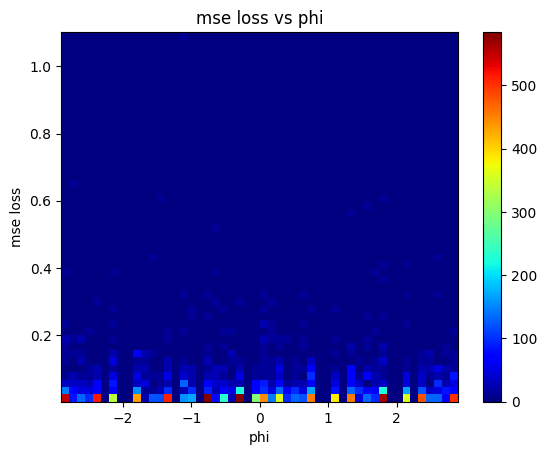

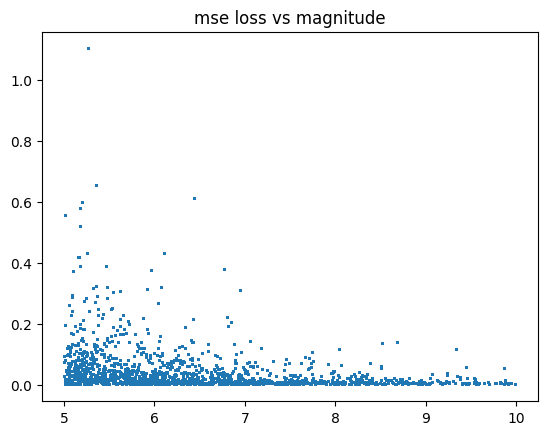

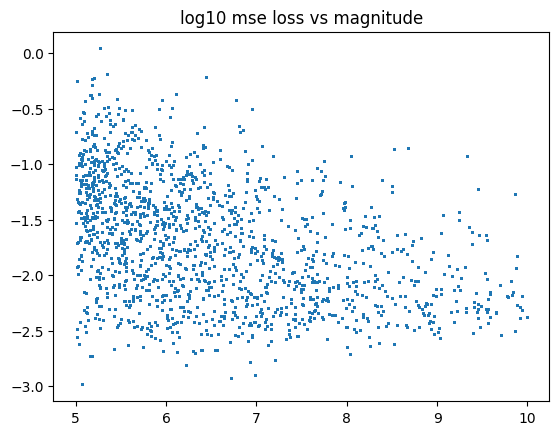

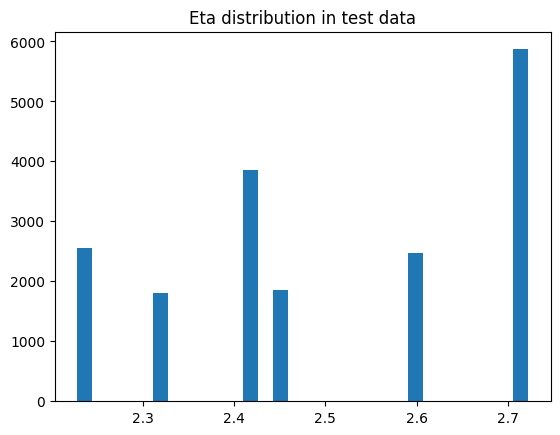

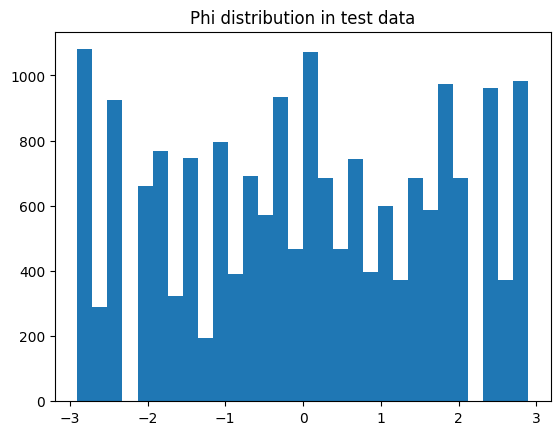

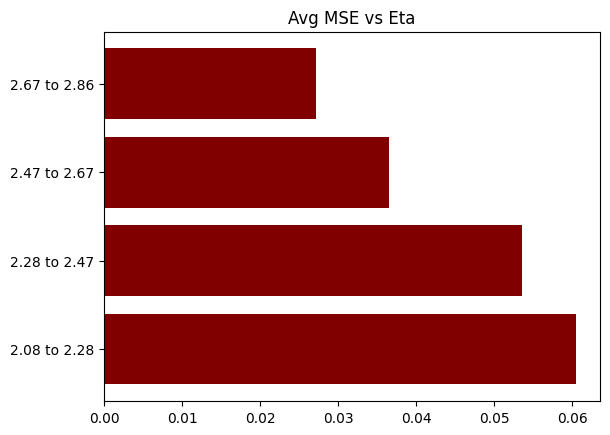

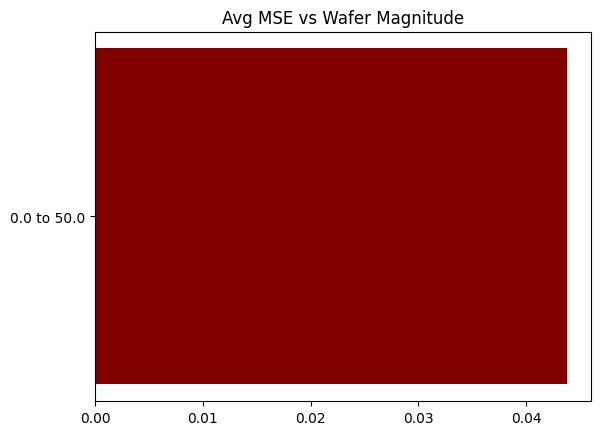

TRAINING MODEL outlier
Epoch 0, lr 0.0015
Epoch 0: Train 86.7542257166897, Test 187.64437866210938
Epoch 1, lr 0.0015
Epoch 1: Train 102.33386238374858, Test 317.7034606933594
Epoch 2, lr 0.0015
Epoch 2: Train 125.8880622745178, Test 533.4497680664062
Epoch 3, lr 0.0015
Epoch 3: Train 116.19415454172717, Test 254.05679321289062
Epoch 4, lr 0.0015
Epoch 4: Train 126.22879927146002, Test 402.136474609375
Epoch 5, lr 0.0015
Epoch 5: Train 111.02508136027835, Test 208.6881561279297
Epoch 6, lr 0.0015
Epoch 6: Train 108.53126495736868, Test 384.083984375
Epoch 7, lr 0.0015
Epoch 7: Train 79.96253522072432, Test 230.78839111328125
Epoch 8, lr 0.0015
Epoch 8: Train 84.40542847875486, Test 266.1700744628906
Epoch 9, lr 0.0015
Epoch 9: Train 118.73169594601646, Test 455.1331481933594
Epoch 10, lr 0.0015
Epoch 10: Train 120.89893753664481, Test 463.6661682128906
Epoch 11, lr 0.0015
Epoch 11: Train 106.24052997450754, Test 158.59027099609375
Epoch 12, lr 0.0015
Epoch 12: Train 73.73350735402478, 

Epoch 102, lr 4.6875e-05
Epoch 102: Train 4.642786856605599, Test 1.696566104888916
Epoch 103, lr 4.6875e-05
Epoch 103: Train 3.4127644100491863, Test 1.7673572301864624
Epoch 104, lr 2.34375e-05
Epoch 104: Train 4.0891682151994555, Test 2.070042848587036
Epoch 105, lr 2.34375e-05
Epoch 105: Train 3.6603680332553203, Test 1.1348774433135986
Epoch 106, lr 2.34375e-05
Epoch 106: Train 2.8940374364043766, Test 0.9571254253387451
Epoch 107, lr 2.34375e-05
Epoch 107: Train 2.75649898456786, Test 0.9211322069168091
Epoch 108, lr 2.34375e-05
Epoch 108: Train 2.809522851992765, Test 0.939781904220581
Epoch 109, lr 2.34375e-05
Epoch 109: Train 2.7040850989559155, Test 0.9069276452064514
Epoch 110, lr 2.34375e-05
Epoch 110: Train 2.768117788001663, Test 1.0000886917114258
Epoch 111, lr 2.34375e-05
Epoch 111: Train 2.604898726693089, Test 1.1246094703674316
Epoch 112, lr 2.34375e-05
Epoch 112: Train 2.7758685829880325, Test 1.370572566986084
Epoch 113, lr 2.34375e-05
Epoch 113: Train 2.7188986724

Epoch 196, lr 5.859375e-06
Epoch 196: Train 1.8960398088252761, Test 0.38751497864723206
Epoch 197, lr 5.859375e-06
Epoch 197: Train 1.8966178273096912, Test 0.38212156295776367
Epoch 198, lr 5.859375e-06
Epoch 198: Train 1.8900527621913759, Test 0.3861543834209442
Epoch 199, lr 5.859375e-06
Epoch 199: Train 1.893659358959973, Test 0.38583993911743164
MSE 0.03228325396776199
Median 0.00029065486160106957
Standard Devitaion 0.1469334214925766
Average std error 0.2678622007369995
Average % Error of Energy Reconstruction 2.2754337787628174


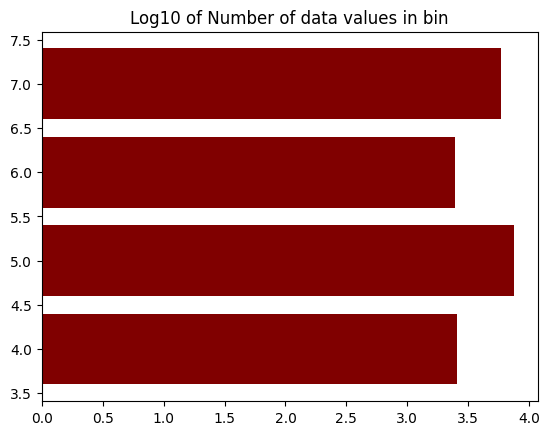

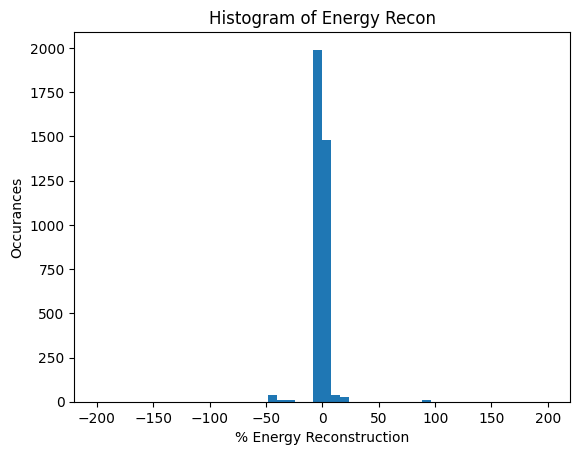

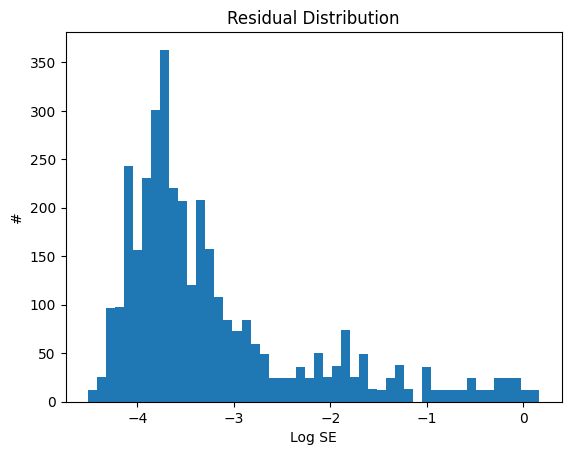

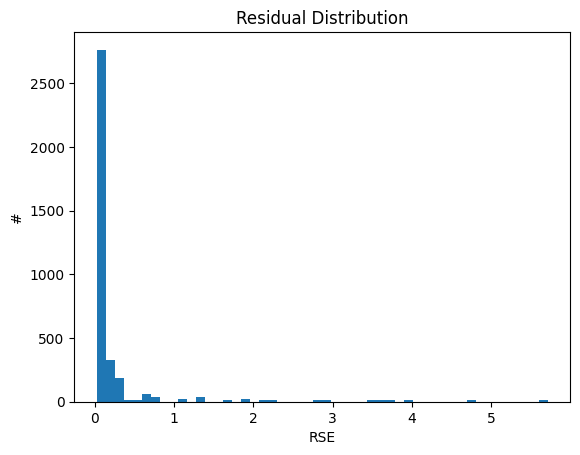

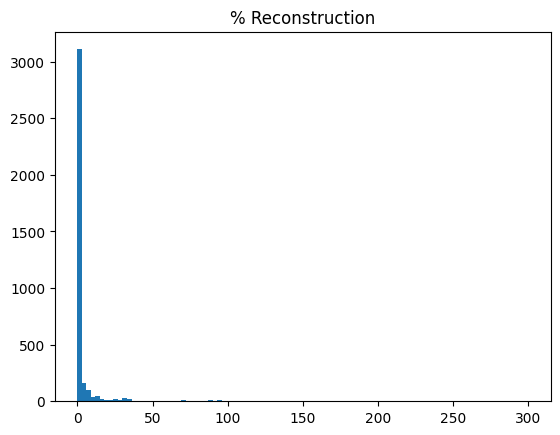

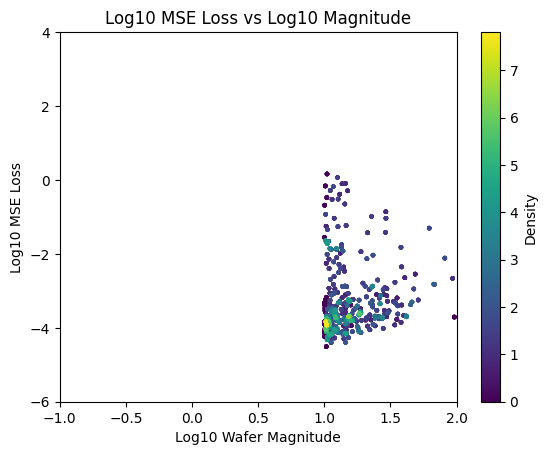

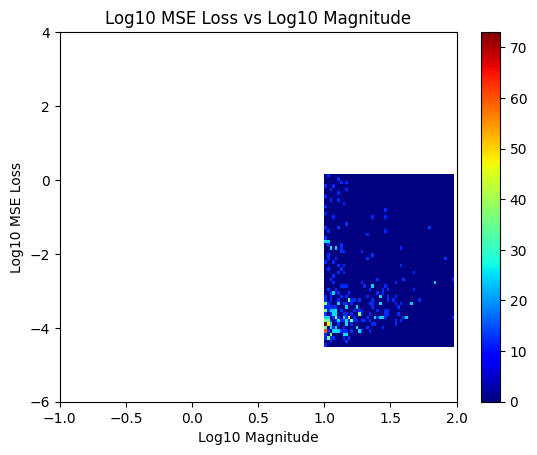

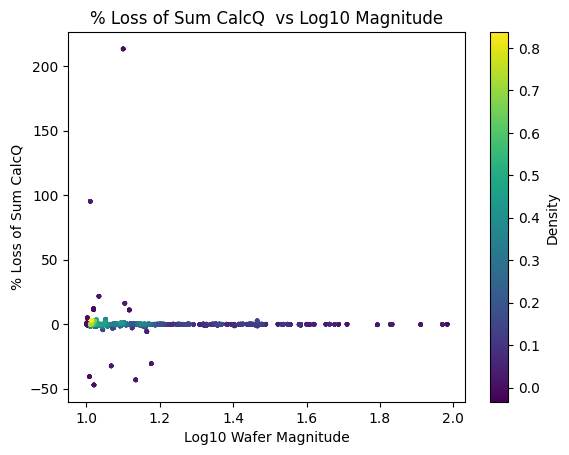

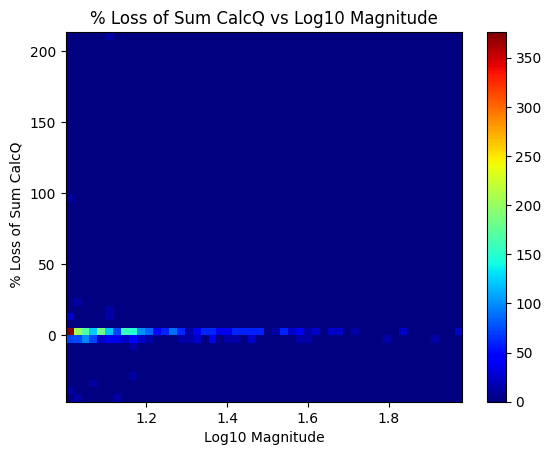

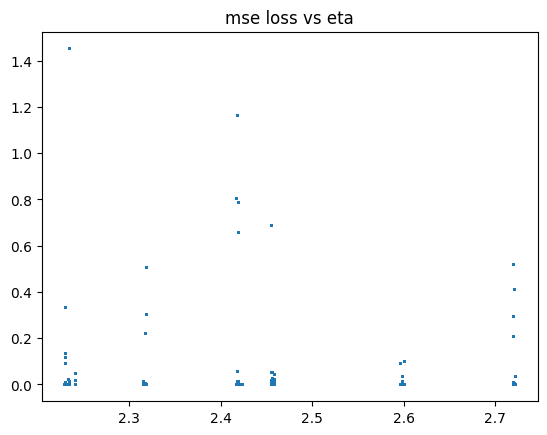

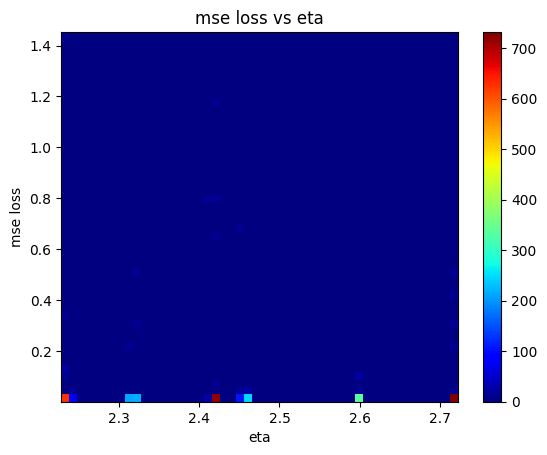

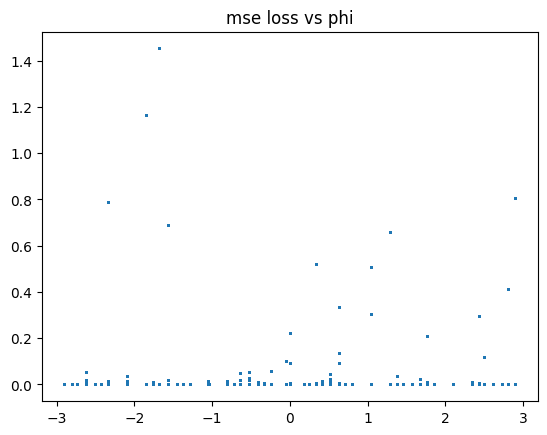

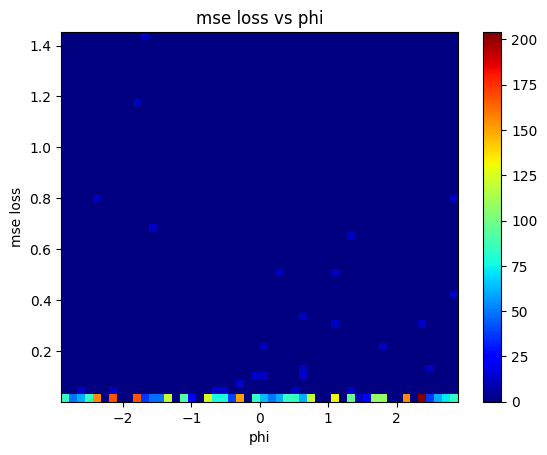

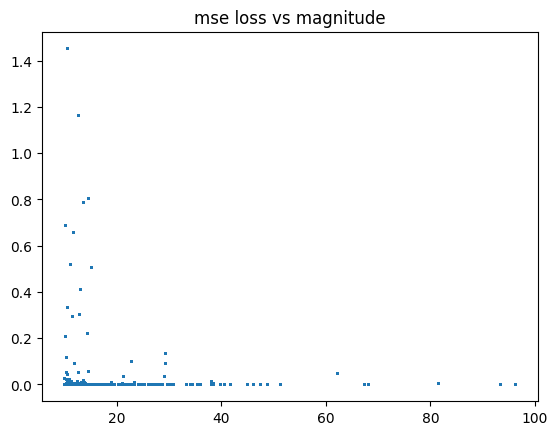

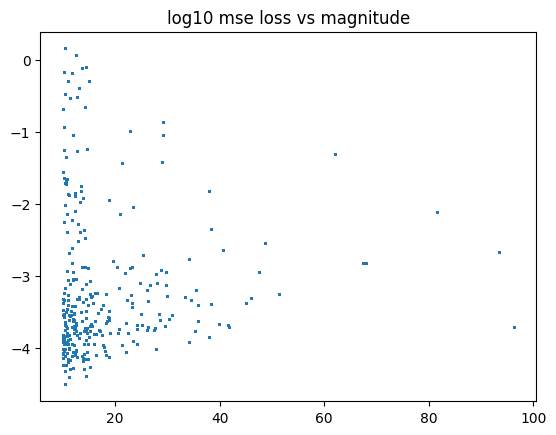

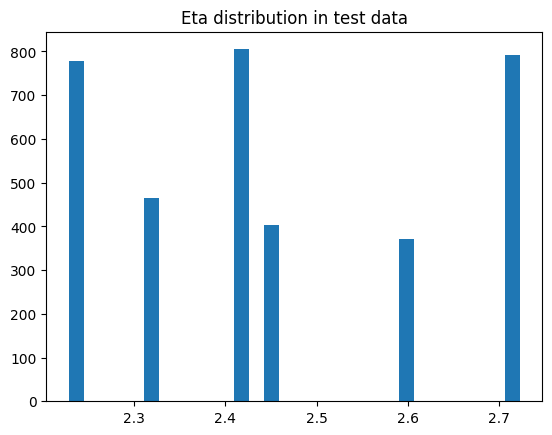

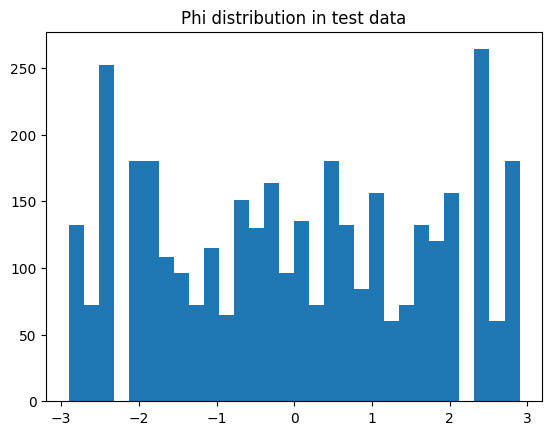

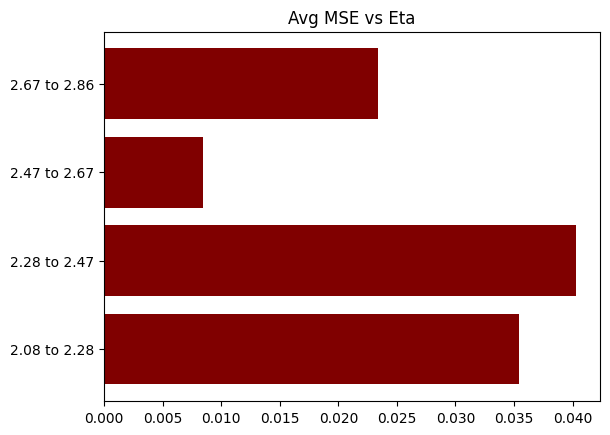

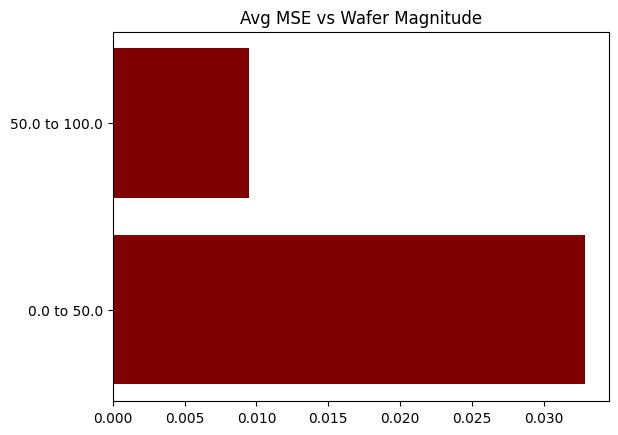

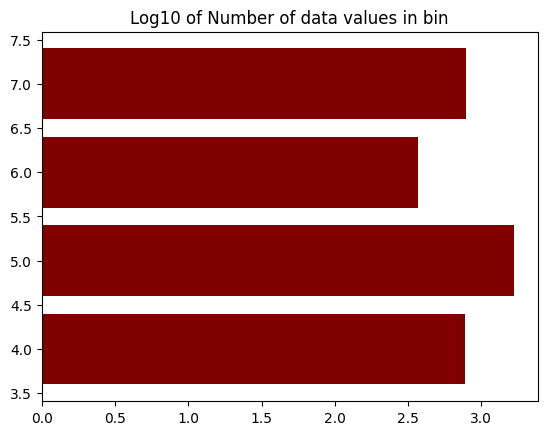

In [39]:
# train_models(data,'batch_4_models_tt_bar_norm_mean_0_var_1')
train_models(data,'batch_4_models_tt_bar_norm_mean_0_var_1')

# Development and Testing Training

## Outlier AE

In [52]:
size_outlier_train =18000
size_outlier_test = 6000
train_loc = dt_outlier[0:size_outlier_train]
test_loc = dt_outlier[-size_outlier_test:]
# train = torch.vstack([train,largest[0:1000]] )
train_loc=train_loc[torch.randperm(train_loc.size()[0])]
test_loc=test_loc[torch.randperm(test_loc.size()[0])]
train_loc_d1_flat = DataLoader(
    TensorDataset(torch.Tensor(train_loc)),
    batch_size=100,
    shuffle=False
)

test_loc_d1_flat = DataLoader(
    TensorDataset(torch.Tensor(test_loc)),
    batch_size=100,
    shuffle=False
)

train = dt_outlier[0:size_outlier_train,0:48]
test = dt_outlier[-size_outlier_test:,0:48]
# train = torch.vstack([train,largest[0:1000]] )
train=train[torch.randperm(train.size()[0])]
test=test[torch.randperm(test.size()[0])]
train_outlier_d1_flat = DataLoader(
    TensorDataset(torch.Tensor(train)),
    batch_size=100,
    shuffle=False
)

test_outlier_d1_flat = DataLoader(
    TensorDataset(torch.Tensor(test)),
    batch_size=100,
    shuffle=False
)

MSE 0.00022176126367412508
Median 3.472687239991501e-05
Standard Devitaion 0.0023483664263039827
Average std error 0.03807436674833298
Average % Error of Energy Reconstruction 0.09778258204460144


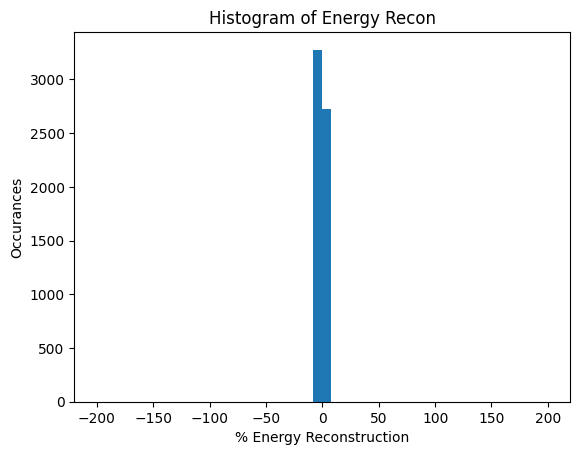

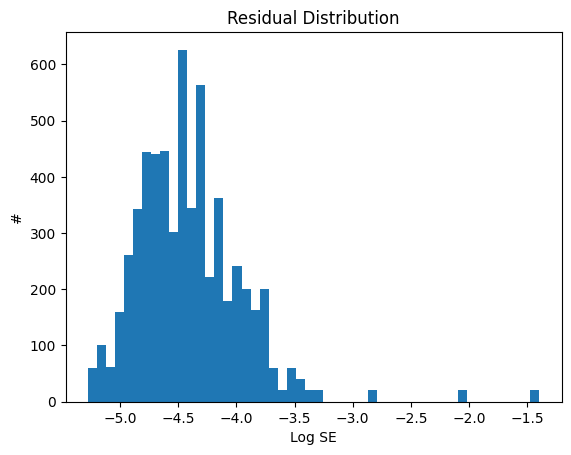

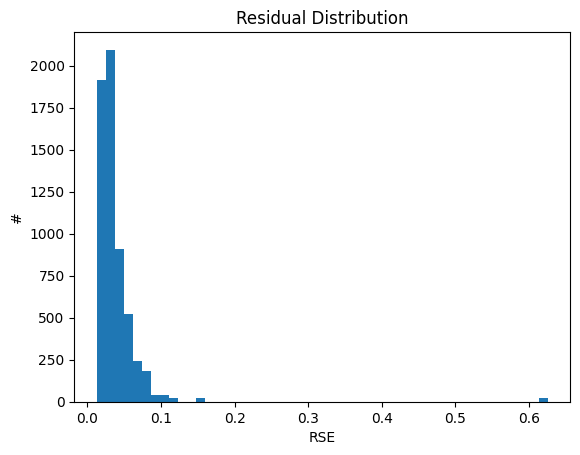

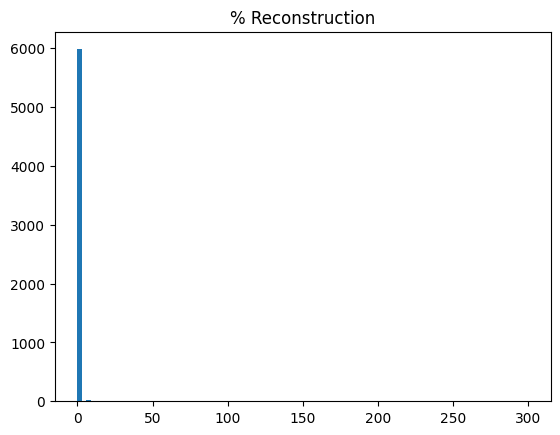

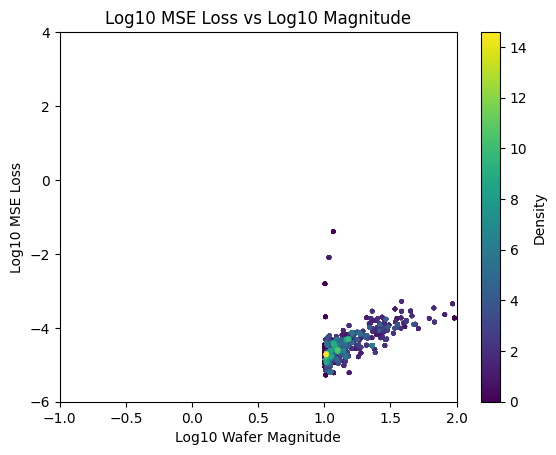

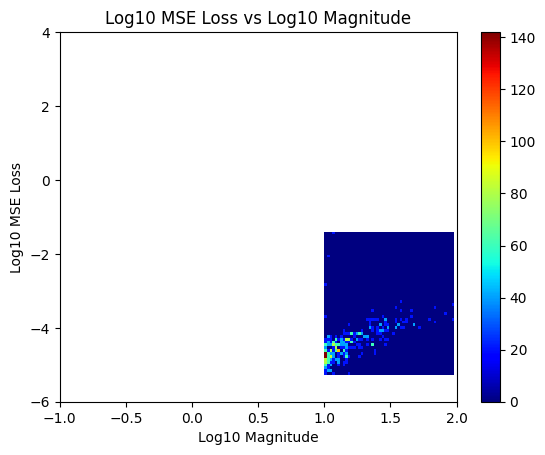

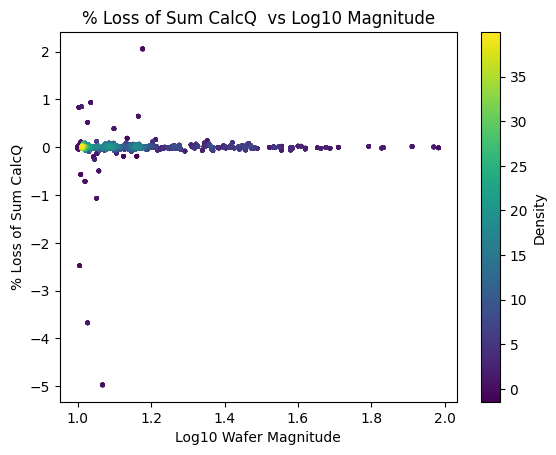

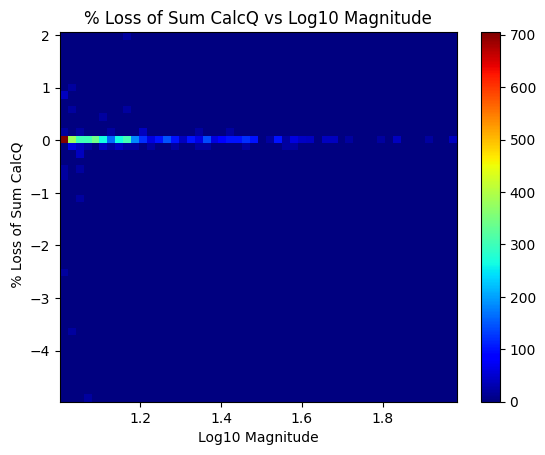

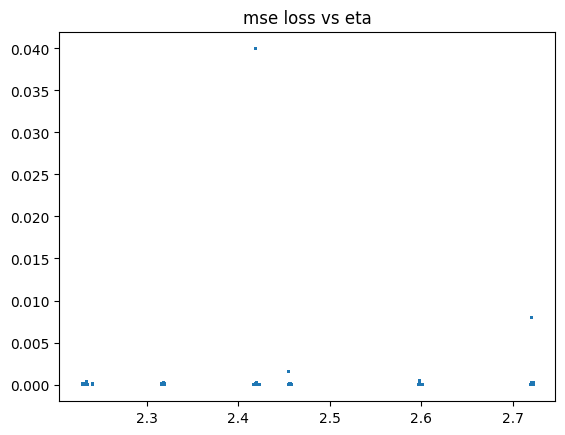

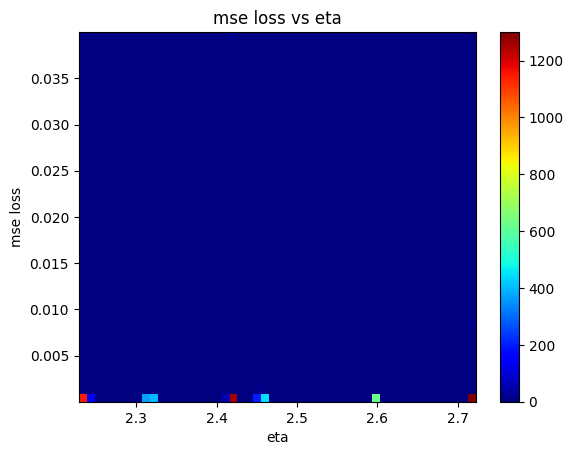

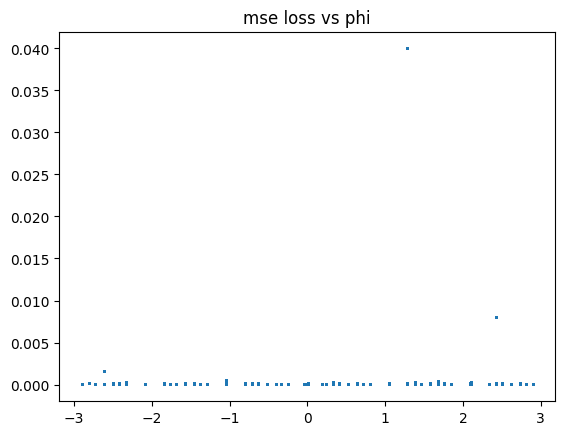

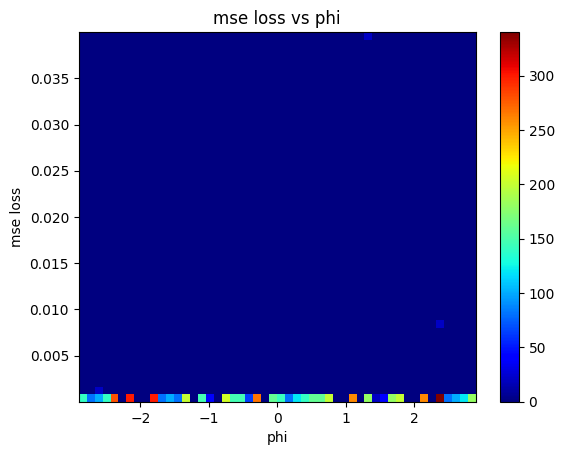

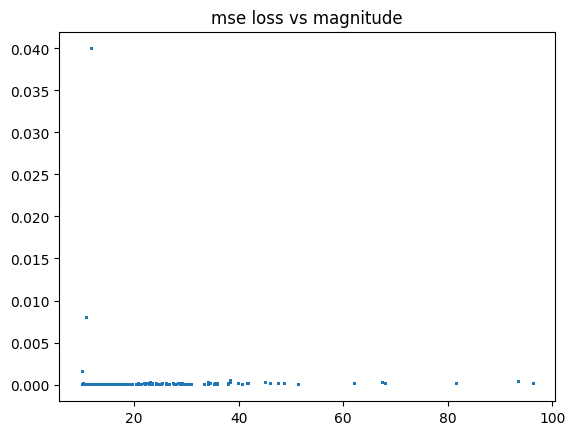

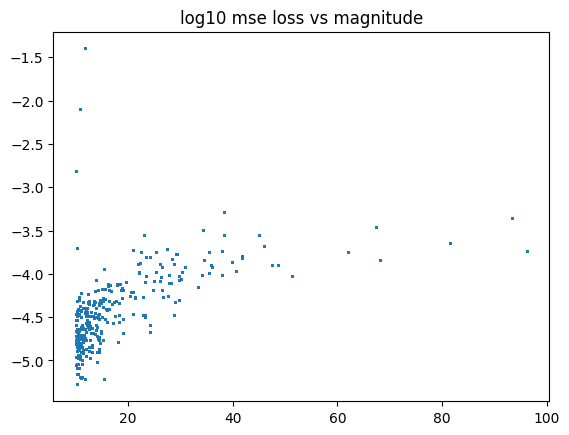

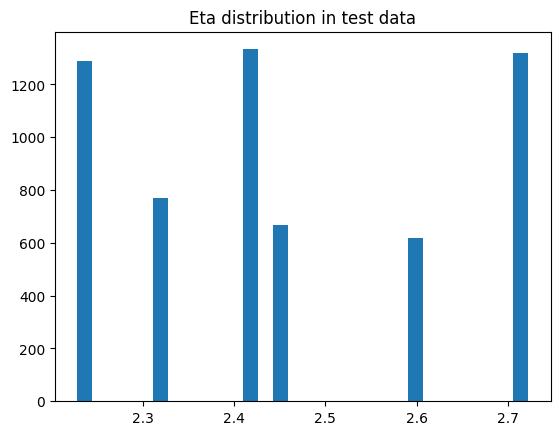

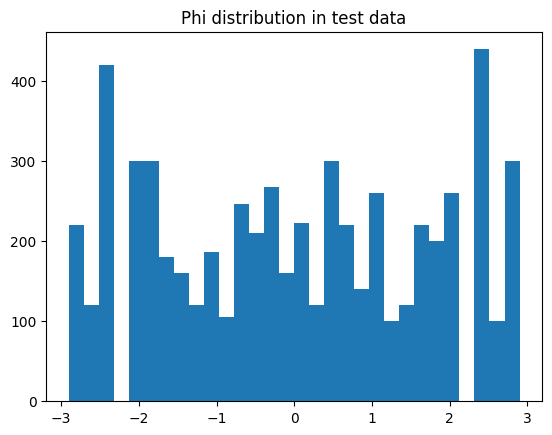

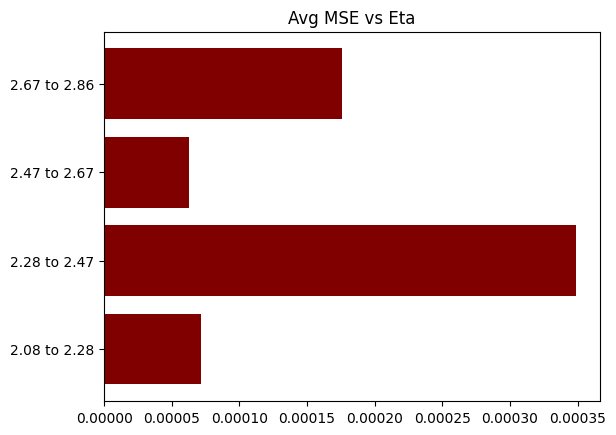

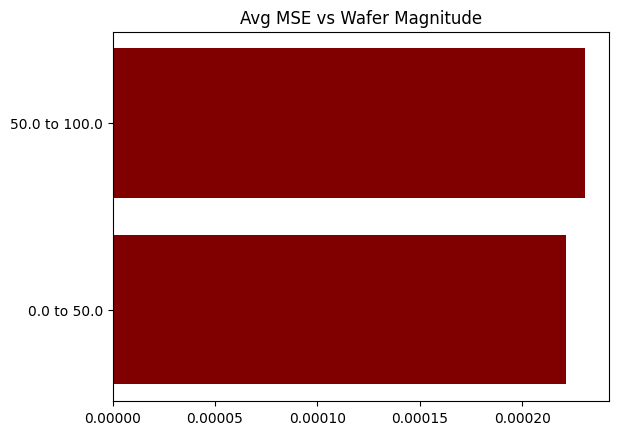

tensor([[ 2.3173e+00,  2.2389e-03,  1.0368e+01,  1.6297e-05,  1.9329e-02],
        [ 2.3173e+00,  2.2389e-03,  2.0993e+01,  6.1651e-05,  4.1461e-02],
        [ 2.3173e+00,  2.2389e-03,  8.1497e+01,  2.2654e-04,  8.0219e-02],
        ...,
        [ 2.2403e+00, -6.3815e-01,  1.4781e+01,  4.5986e-05,  3.2256e-02],
        [ 2.2403e+00, -6.3815e-01,  1.3841e+01,  4.0276e-05,  2.9776e-02],
        [ 2.2403e+00, -6.3815e-01,  6.2085e+01,  1.7996e-04,  5.4986e-02]],
       grad_fn=<CatBackward0>)

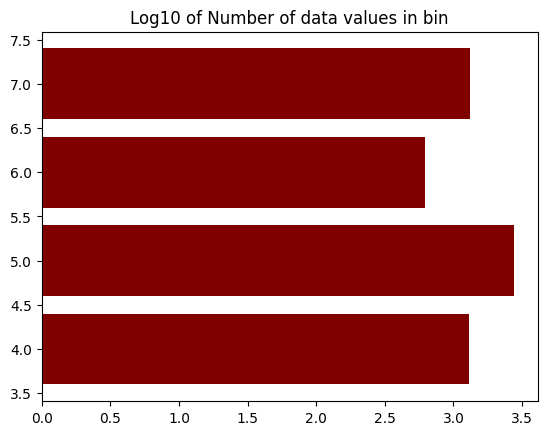

In [53]:
#fine-tune autoencoder
#batch 500


'''
Works for mean =0, var = 1
Outliers all wafers with norm > 10

Gets perfect encoding on these

'''


loss = new_loss
mean = mean_dt_1
std = std_dt_1
# model_outlier = Naive_DAE([48,450,250,100,16]).to(device)
# model_outlier = torch.load('models/dt_1_outlier_greater_0_1').to(device)
test = dt_outlier[-size_outlier_test:,0:48]
lr = 0.00000045
num_epochs = 100
a = 0.001

optimizer = optim.Adam(model_outlier.parameters(), lr,weight_decay=5e-2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',factor = 0.5)
test = dt_outlier[-size_outlier_test:,0:48]

all_outlier_test_losses = []
all_outlier_train_losses = []
# train
running_loss = float("inf")
for epoch in range(num_epochs):
    break
    losses = []
    
    for i, data_list in enumerate(train_outlier_d1_flat):
        model_outlier.train()
        data = data_list[0]
        v_pred = model_outlier(data)
        
#         batch_loss = loss(data[:,0:48], v_pred,epoch,std_dt_outlier,mean_dt_outlier,alpha = a) # difference between actual and reconstructed   
        batch_loss = loss(data[:,0:48], v_pred,epoch,mean,std)
        
        all_outlier_train_losses.append(batch_loss.item())
        losses.append(batch_loss.item())
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
    scheduler.step(batch_loss)
    data_outlier_test = test
    model_outlier.eval()
    test_pred = model_outlier(data_outlier_test)
    batch_outlier_test = loss(data_outlier_test[:,0:48], test_pred,epoch,mean,std)
    all_outlier_test_losses.append(batch_outlier_test.item())
    running_loss = np.mean(losses)
    running_outlierest_loss = batch_outlier_test.item()
    print('Epoch {}, lr {}'.format(
        epoch, optimizer.param_groups[0]['lr']))
    
    print(f"Epoch {epoch}: Train {running_loss}, Test {running_outlierest_loss}")
model_outlier.eval()
AE_Stats.gen_all_stats(model_outlier(dt_outlier[-size_outlier_test:,0:48]).cpu(),dt_outlier[-size_outlier_test:,0:48].cpu(),dt_outlier[-size_outlier_test:].cpu())
# torch.save(model_outlier,'models/dt_1_outlier_greater_0_3')

In [85]:
%ls models

2023-03-21_04-21_model_trainings/
2023-03-21_04-23-57_model_trainings/
2023-03-21_15-27-08_model_trainings/
2023-03-21_19-41-12_model_trainings/
2023-03-22_04-38-55_model_trainings/
2023-03-22_04-39-30_model_trainings/
2023-03-22_04-40-34_model_trainings/
2023-03-22_04-40-45_model_trainings/
batch_4_models_tt_bar_norm_mean_0_var_1_model_trainings/
cur_dir/
dt_1_greater_0_250_100
dt_1_greater_0_250_100_dif
dt_1_greater_0_250_100_log
dt_1_greater_0_450_250_100_dif
dt_1_greater_0_450_250_100_dif_2
dt_1_greater_0_450_250_100_dif_high_alpha
dt_1_greater_0_450_250_100_dif_low_alpha
dt_1_greater_0_450_250_100_log_2
dt_1_greater_0_800_250_100_dif
dt_1_greater_0_avg
dt_1_greater_0_low
dt_1_greater_0_low_1
dt_1_greater_0_low_2
dt_1_greater_0_low_3
dt_1_greater_0_m1
dt_1_greater_0_m2
dt_1_greater_0_mid_1
dt_1_greater_0_mid_2
dt_1_greater_0_mid_3
dt_1_outlier_greater_0
dt_1_outlier_greater_0_1
dt_2_greater_0_250_100
dt_2_greater_0_250_100_dif
dt_2_greater_0_250_100_log
dt_2_greater_0_450_250_100_d

In [86]:
torch.load('models/dt_1_greater_0_low_3').parameters

<bound method Module.parameters of Naive_DAE(
  (encoders): ModuleList(
    (0): Linear(in_features=48, out_features=450, bias=True)
    (1): ReLU()
    (2): Linear(in_features=450, out_features=250, bias=True)
    (3): ReLU()
    (4): Linear(in_features=250, out_features=100, bias=True)
    (5): ReLU()
    (6): Linear(in_features=100, out_features=16, bias=True)
    (7): ReLU()
  )
  (decoders): ModuleList(
    (0): ReLU()
    (1): Linear(in_features=16, out_features=100, bias=True)
    (2): ReLU()
    (3): Linear(in_features=100, out_features=250, bias=True)
    (4): ReLU()
    (5): Linear(in_features=250, out_features=450, bias=True)
    (6): ReLU()
    (7): Linear(in_features=450, out_features=48, bias=True)
  )
)>

In [55]:
torch.round(model_outlier(dt_outlier[-size_outlier_test:,0:48])[0]*std_dt_1 + mean_dt_1)

tensor([  5.,   8.,   0.,  57.,  23.,   5.,  85.,  72., 105.,  14., 175.,  38.,
          0.,   0.,   0., 174.,  15.,  13.,   0.,   9.,  13.,  33.,  40.,  43.,
         11.,  52.,  48.,   3.,  53., 339.,   7.,   8., 369.,  79.,   3.,  39.,
          4.,  32.,  17.,  13.,  11.,   6.,  -0.,  -0.,   0.,  -0.,   0.,  12.],
       device='cuda:0', grad_fn=<RoundBackward0>)

In [54]:
torch.round(dt_outlier[-size_outlier_test:,0:48][0]*std_dt_1 + mean_dt_1)

tensor([  5.,   8.,   0.,  57.,  23.,   5.,  85.,  72., 105.,  14., 175.,  38.,
          0.,   0.,   0., 174.,  15.,  13.,   0.,   9.,  13.,  33.,  40.,  43.,
         11.,  52.,  48.,   3.,  53., 339.,   7.,   8., 369.,  79.,   3.,  39.,
          4.,  32.,  17.,  13.,  11.,   6.,   0.,   0.,   0.,   0.,   0.,  12.],
       device='cuda:0')

## Notes:
Remarkable perforamnce on the higher range for wafer norm. It seems that the larger dataset is not performing very well.

Try splitting into the smaller range too. 

In [18]:
size_low_train =40000
size_low_test = 10000
train_loc = dt_low[0:size_low_train]
test_loc = dt_low[-size_low_test:]
# train = torch.vstack([train,largest[0:1000]] )
train_loc=train_loc[torch.randperm(train_loc.size()[0])]
test_loc=test_loc[torch.randperm(test_loc.size()[0])]
train_loc_d1_flat = DataLoader(
    TensorDataset(torch.Tensor(train_loc)),
    batch_size=100,
    shuffle=False
)

test_loc_d1_flat = DataLoader(
    TensorDataset(torch.Tensor(test_loc)),
    batch_size=100,
    shuffle=False
)

train = dt_low[0:size_low_train,0:48]
test = dt_low[-size_low_test:,0:48]
# train = torch.vstack([train,largest[0:1000]] )
train=train[torch.randperm(train.size()[0])]
test=test[torch.randperm(test.size()[0])]
train_low_d1_flat = DataLoader(
    TensorDataset(torch.Tensor(train)),
    batch_size=100,
    shuffle=False
)

test_low_d1_flat = DataLoader(
    TensorDataset(torch.Tensor(test)),
    batch_size=100,
    shuffle=False
)


In [22]:
#fine-tune autoencoder
#batch 500
# model_low = Naive_DAE([48,450,250,100,16]).to(device)
model_low = torch.load('models/dt_1_greater_0_450_250_100_dif_2').to(device)
test = dt_low[-size_low_test:,0:48]
lr = 0.0045
num_epochs = 50
a = 0.001

optimizer = optim.Adam(model_low.parameters(), lr,weight_decay=5e-2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',factor = 0.5)
test = dt_low[-size_low_test:,0:48]

all_low_test_losses = []
all_low_train_losses = []
# train
running_loss = float("inf")
for epoch in range(num_epochs):
    
    losses = []
    
    for i, data_list in enumerate(train_low_d1_flat):
        model_low.train()
        data = data_list[0]
        v_pred = model_low(data)
        
#         batch_loss = loss(data[:,0:48], v_pred,epoch,std_dt_low,mean_dt_low,alpha = a) # difference between actual and reconstructed   
        batch_loss = loss(data[:,0:48], v_pred,epoch,mean,std)
        
        all_low_train_losses.append(batch_loss.item())
        losses.append(batch_loss.item())
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
    scheduler.step(batch_loss)
    data_low_test = test
    model_low.eval()
    test_pred = model_low(data_low_test)
    batch_low_test = loss(data_low_test[:,0:48], test_pred,epoch,mean,std)
    all_low_test_losses.append(batch_low_test.item())
    running_loss = np.mean(losses)
    running_lowest_loss = batch_low_test.item()
    print('Epoch {}, lr {}'.format(
        epoch, optimizer.param_groups[0]['lr']))
    
    print(f"Epoch {epoch}: Train {running_loss}, Test {running_lowest_loss}")
model_low.eval()
AE_Stats.gen_all_stats(model_low(dt_low[-size_low_test:,0:48]).cpu(),dt_low[-size_low_test:,0:48].cpu(),dt_low[-size_low_test:].cpu())
# torch.save(model_low,'models/dt_1_greater_0_low_3')

Epoch 0, lr 0.0045
Epoch 0: Train 13.438290688991547, Test 10.492935180664062
Epoch 1, lr 0.0045
Epoch 1: Train 10.082224776744843, Test 9.261885643005371
Epoch 2, lr 0.0045
Epoch 2: Train 9.09714224100113, Test 8.506538391113281
Epoch 3, lr 0.0045
Epoch 3: Train 8.589912085533141, Test 8.152498245239258
Epoch 4, lr 0.0045
Epoch 4: Train 8.101752859354018, Test 7.610170364379883
Epoch 5, lr 0.0045
Epoch 5: Train 7.810421808958053, Test 7.407725811004639
Epoch 6, lr 0.0045
Epoch 6: Train 7.528729159832, Test 7.274170398712158
Epoch 7, lr 0.0045
Epoch 7: Train 7.42143131017685, Test 7.076728820800781
Epoch 8, lr 0.0045
Epoch 8: Train 7.249093216657639, Test 6.9892258644104
Epoch 9, lr 0.0045
Epoch 9: Train 7.151880038976669, Test 6.729217052459717


KeyboardInterrupt: 

In [54]:
torch.round(model_low(dt_low[-size_low_test:,0:48])[0]*std_dt_1)

tensor([76., 14.,  0.,  3.,  0.,  0.,  6.,  3.,  0., -0., 42., 10.,  3., -0.,
         9., 47., 60., 24., 39., 18.,  5., 42., 45.,  7., -0., 13., 24., 10.,
        -0., 13.,  3.,  4.,  0., -0., -0., -0., 12.,  7., -0., -0., 26.,  3.,
         7., -0.,  3., 10.,  0.,  0.], device='cuda:0',
       grad_fn=<RoundBackward0>)

In [53]:
torch.round(dt_low[-size_low_test:,0:48][0]*std_dt_1)

tensor([76., 14.,  0.,  3.,  0.,  0.,  6.,  3.,  0.,  0., 42., 10.,  3.,  0.,
         9., 47., 60., 24., 39., 18.,  5., 42., 45.,  7.,  0., 13., 24., 10.,
         0., 13.,  3.,  4.,  0.,  0.,  0.,  0., 12.,  7.,  0.,  0., 26.,  3.,
         7.,  0.,  3., 10.,  0.,  0.], device='cuda:0')

In [40]:
size_mid_train =40000
size_mid_test = 3000
train_loc = dt_mid[0:size_mid_train]
test_loc = dt_mid[-size_mid_test:]
# train = torch.vstack([train,largest[0:1000]] )
train_loc=train_loc[torch.randperm(train_loc.size()[0])]
test_loc=test_loc[torch.randperm(test_loc.size()[0])]
train_loc_d1_flat = DataLoader(
    TensorDataset(torch.Tensor(train_loc)),
    batch_size=100,
    shuffle=False
)

test_loc_d1_flat = DataLoader(
    TensorDataset(torch.Tensor(test_loc)),
    batch_size=100,
    shuffle=False
)

train = dt_mid[0:size_mid_train,0:48]
test = dt_mid[-size_mid_test:,0:48]
# train = torch.vstack([train,largest[0:1000]] )
train=train[torch.randperm(train.size()[0])]
test=test[torch.randperm(test.size()[0])]
train_mid_d1_flat = DataLoader(
    TensorDataset(torch.Tensor(train)),
    batch_size=100,
    shuffle=False
)

test_mid_d1_flat = DataLoader(
    TensorDataset(torch.Tensor(test)),
    batch_size=20,
    shuffle=False
)

MSE 3.353236436843872
Median 3.128110647201538
Standard Devitaion 1.4669839143753052
Average std error 9.3815336227417
Average % Error of Energy Reconstruction 1.8970190286636353


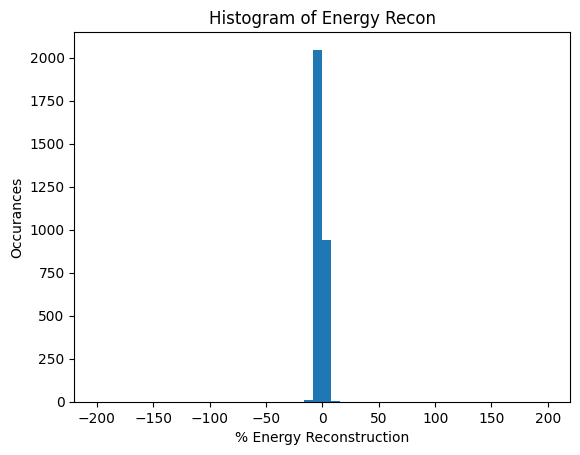

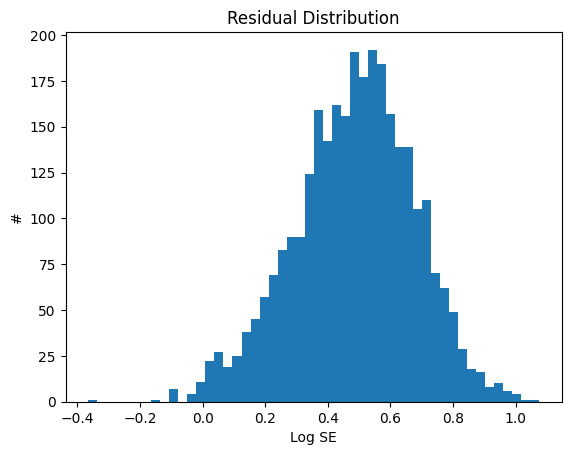

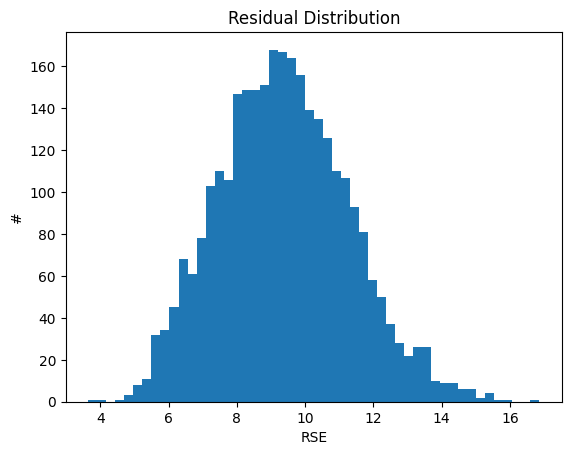

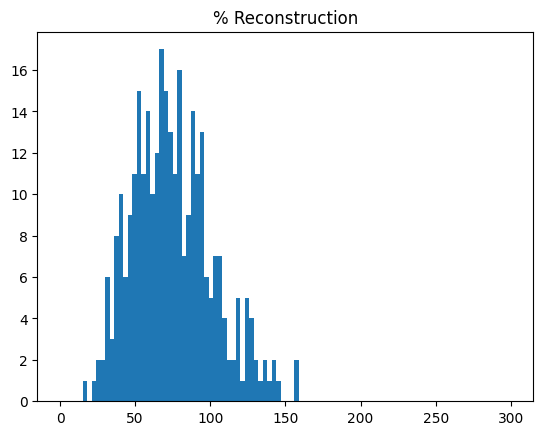

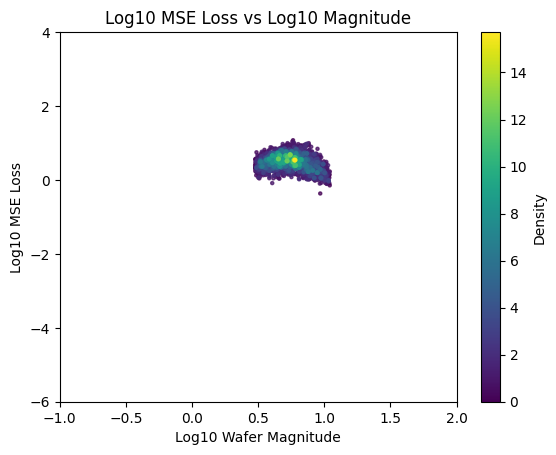

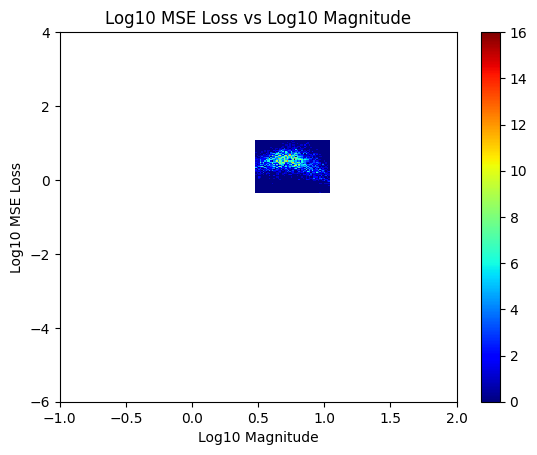

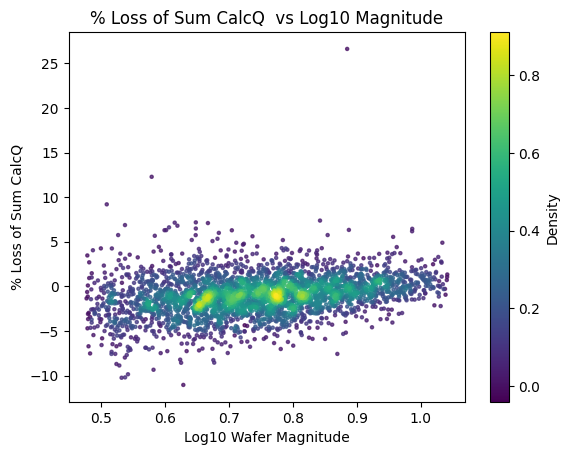

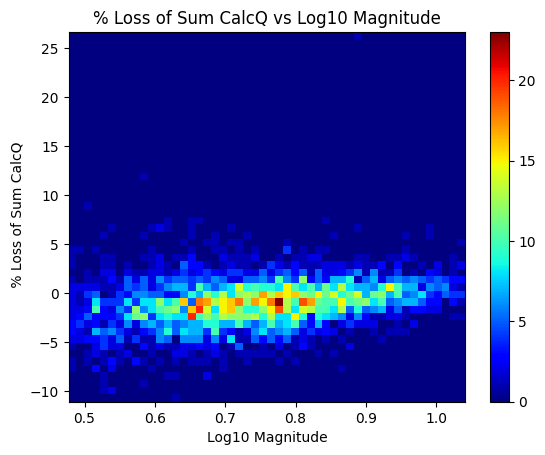

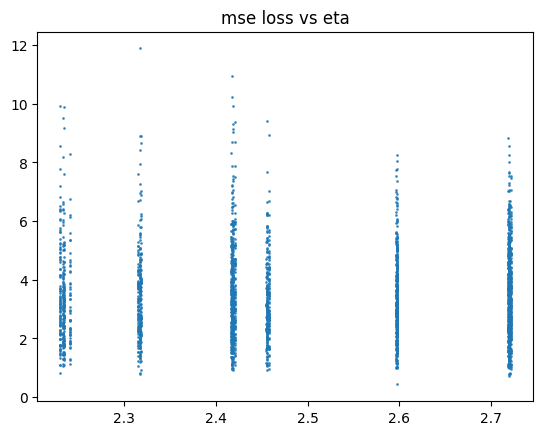

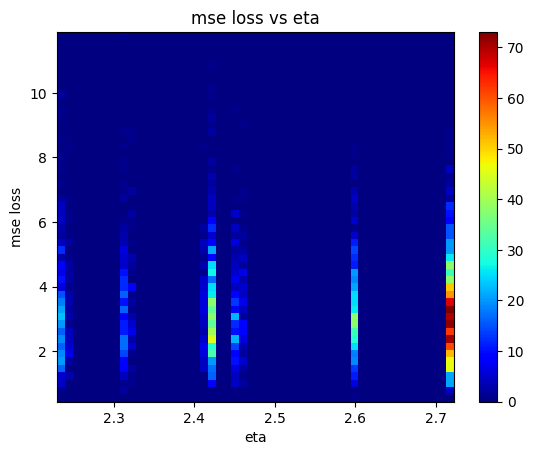

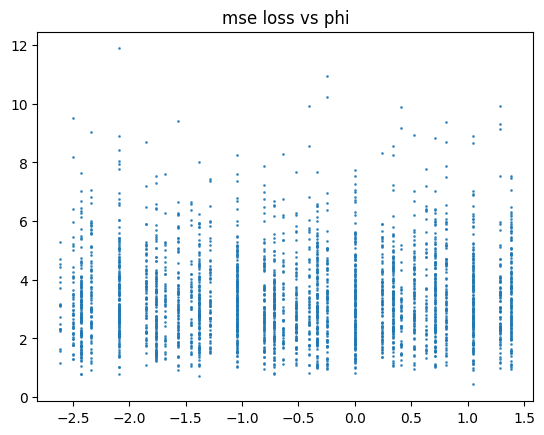

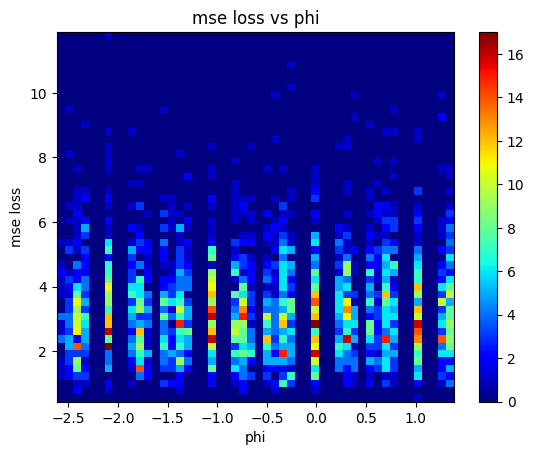

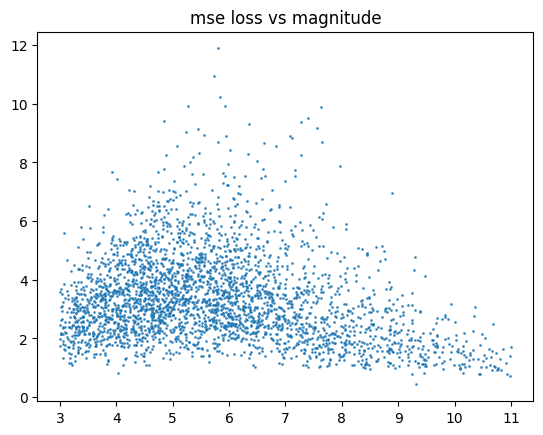

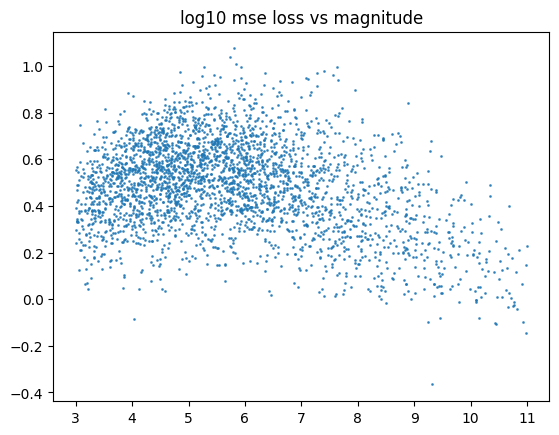

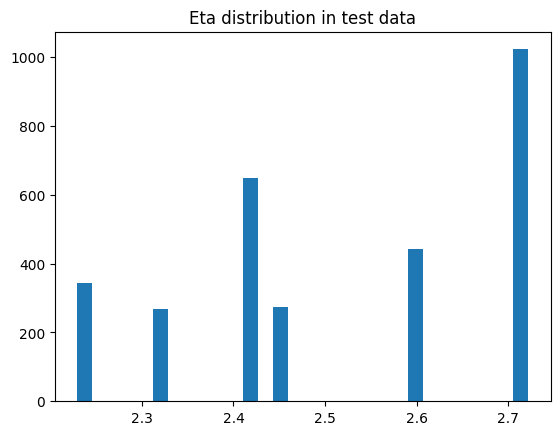

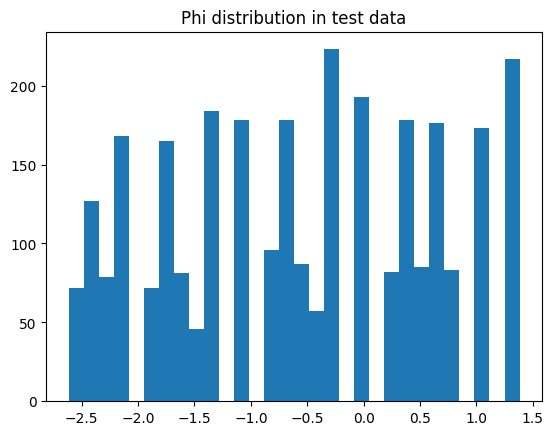

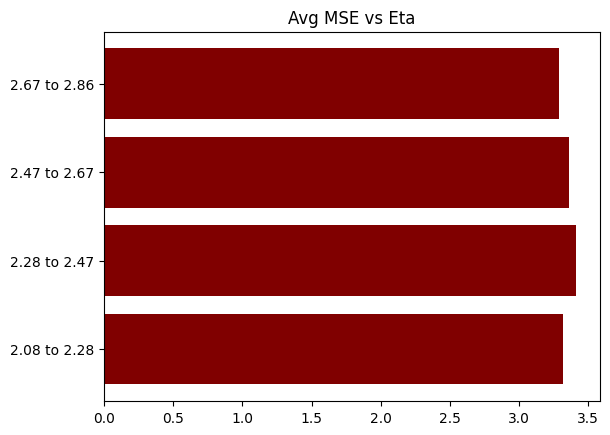

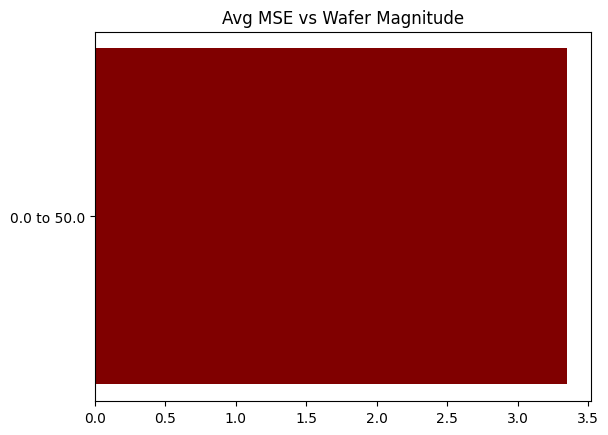

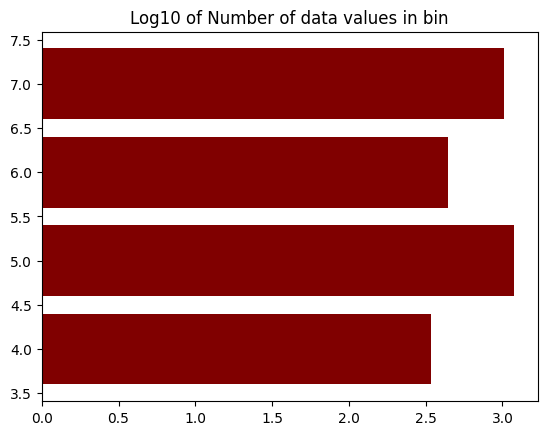

In [58]:
#fine-tune autoencoder
#batch 500
num_epochs = 1000
lr = 0.0001
# model_mid = Naive_DAE([48,450,250,100,16]).to(device)
# model_mid = torch.load('models/dt_1_greater_0_450_250_100_dif_2').to(device)
test = dt_mid[-size_mid_test:,0:48]

a = 0.001

optimizer = optim.Adam(model_mid.parameters(), lr,weight_decay=5e-2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',factor = 0.75)
test = dt_mid[-size_mid_test:,0:48]

all_mid_test_losses = []
all_mid_train_losses = []
# train
running_loss = float("inf")
for epoch in range(num_epochs):
    break
    losses = []
    
    for i, data_list in enumerate(train_mid_d1_flat):
        model_mid.train()
        data = data_list[0]
        v_pred = model_mid(data)
        
#         batch_loss = loss(data[:,0:48], v_pred,epoch,std_dt_mid,mean_dt_mid,alpha = a) # difference between actual and reconstructed   
        batch_loss = loss(data[:,0:48], v_pred,epoch,mean,std)
        
        all_mid_train_losses.append(batch_loss.item())
        losses.append(batch_loss.item())
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
    scheduler.step(batch_loss)
    data_mid_test = test
    model_mid.eval()
    test_pred = model_mid(data_mid_test)
    batch_mid_test = loss(data_mid_test[:,0:48], test_pred,epoch,mean,std)
    all_mid_test_losses.append(batch_mid_test.item())
    running_loss = np.mean(losses)
    running_midest_loss = batch_mid_test.item()
    print('Epoch {}, lr {}'.format(
        epoch, optimizer.param_groups[0]['lr']))
    
    print(f"Epoch {epoch}: Train {running_loss}, Test {running_midest_loss}")
model_mid.eval()
AE_Stats.gen_all_stats(model_mid(dt_mid[-size_mid_test:,0:48]).cpu(),dt_mid[-size_mid_test:,0:48].cpu(),dt_mid[-size_mid_test:].cpu())
torch.save(model_mid,'models/dt_1_greater_0_mid_3')